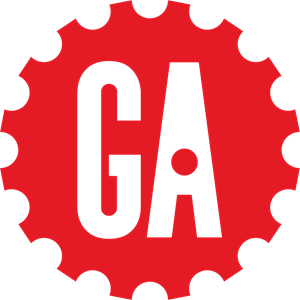

# Capstone Project: ML, Brain Tumors & MRI

Constance Lin | DSI-41

<b> Notebook 1: Using CNN pre-trained models on MRI Brain Tumour dataset </b>

<br>

<b> Contents of notebook: </b>
1. Image extraction from Google drive
  * Mounting Google drive to Colab for image extraction
  * Import in data
  * Splitting testing images to Validation dataset and Testing dataset

2. EDA on data
  * Class balancing for Training data
  * Visualization for Validation data

3. Image preprocessing
  * Image augmentation & visualization for Training data
  * Image augmentation & visualization for Validation data

4. Modeling & Metric tracking
  * VGG-16 & ResNet50
    * Customising the model
    * Training the model: Version 1, Version 2, Version 3
    * Plotting the accuracy and loss graphs
    * Model evaluation on Testing data
  * EfficientNetB2
    * Reprocessing the image input shape
    * Customising the model
    * Training the model: Version 1, Version 2, Version 3
    * Plotting the accuracy and loss graphs
    * Model evaluation on Testing data

5. Summary


### Part 1: Image Extraction from Google drive

#### Mounting Google drive to Colab for image extraction

The folder that contains all the images are zipped in in `archive.zip`

In [ ]:
# mounting google drive onto colab
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# check for content in google drive 
# depending on your individual google drive, it could look different
!ls "/content/drive/My Drive"

 Church		       'KTPH Competency'			'NYP_Diagnostic Radiography'
'Colab Notebooks'      'KTPH Training materials'		'Python Course'
'GA Outcomes Related'  'NTU Coursera course Forensics Science'
 GA_Projects	       'NUS TMR'


In [ ]:
# look for the archive folder where the images are located
# depending on where the archive.zip folder is located
!ls "/content/drive/My Drive/GA_Projects/Capstone"

 archive.zip  'Capstone Presentation 1.gslides'


In [ ]:
# unzip the correct folder and store in a new folder (i named it "images", in this case) in google drive
!unzip -u "/content/drive/My Drive/GA_Projects/Capstone/archive.zip" -d "/content/drive/My Drive/GA_Projects/Capstone/Images"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/GA_Projects/Capstone/Images/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/drive/My Drive/GA_Projects/Capstone/Images/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/drive/My Drive/GA_Projects/Capstone/Images/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/drive/My Drive/GA_Projects/Capstone/Images/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/drive/My Drive/GA_Projects/Capstone/Images/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/drive/My Drive/GA_Projects/Capstone/Images/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/drive/My Drive/GA_Projects/Capstone/Images/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/drive/My Drive/GA_Projects/Capstone/Images/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/drive/My Drive/GA_Projects/Capstone/Images/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/drive/My Drive/GA_Projects/Capstone/Images/Tr

#### Import in libraries

In [ ]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data handling imports
import os
from PIL import Image
import itertools
from skimage.io import imread

# modelling imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample

# cnn imports
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.applications import VGG16, ResNet50, EfficientNetB2
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# to seed our notebook so we get reproducible results
tf.keras.utils.set_random_seed(42)

#### Import in data

First we need to import in the images and ensure that the correct labels are given to each image.

There are 5712 training images and 1311 testing images.

In [ ]:
# specify which folder our data is stored on colab
# colab does not allow relative file paths it has to be exact
train_data_directory = "/content/drive/My Drive/GA_Projects/Capstone/Images/Training"
list_training_directory = os.listdir(train_data_directory)

# create 2 empty list to contain each individual filepath and labels
# we will concat them together as 2 columns later to create our final dataframe
filepaths = []
labels = []

# first we access the folder in our train_data_directory i.e. glioma, meningioma, normal, pituitary
for folder in list_training_directory:
  folder_path = os.path.join(train_data_directory, folder)
  # then we access each image in the folder
  image_list = os.listdir(folder_path)

  # for each image, we take the filepath and put a label to it
  for image in image_list:
    fpath = os.path.join(folder_path, image)

    # append the filepath and the image label (which is the folder name) to respective lists
    filepaths.append(fpath)
    labels.append(folder)

# convert each list to a numpy series and then concat them into one dataframe
series_filepaths = pd.Series(filepaths, name = "filepaths")
series_labels = pd.Series(labels, name = "labels")

train_df = pd.concat([series_filepaths, series_labels], axis= 1)
train_df

filepaths     labels
0     /content/drive/My Drive/GA_Projects/Capstone/I...     glioma
1     /content/drive/My Drive/GA_Projects/Capstone/I...     glioma
2     /content/drive/My Drive/GA_Projects/Capstone/I...     glioma
3     /content/drive/My Drive/GA_Projects/Capstone/I...     glioma
4     /content/drive/My Drive/GA_Projects/Capstone/I...     glioma
...                                                 ...        ...
5707  /content/drive/My Drive/GA_Projects/Capstone/I...  pituitary
5708  /content/drive/My Drive/GA_Projects/Capstone/I...  pituitary
5709  /content/drive/My Drive/GA_Projects/Capstone/I...  pituitary
5710  /content/drive/My Drive/GA_Projects/Capstone/I...  pituitary
5711  /content/drive/My Drive/GA_Projects/Capstone/I...  pituitary

[5712 rows x 2 columns]

In [ ]:
# specify which folder our data is stored on colab
# colab does not allow relative file paths it has to be exact
test_data_directory = "/content/drive/My Drive/GA_Projects/Capstone/Images/Testing"
list_testing_directory = os.listdir(test_data_directory)

# create 2 empty list to contain each individual filepath and labels
# we will concat them together as 2 columns later to create our final dataframe
filepaths = []
labels = []

# first we access the folder in our train_data_directory i.e. glioma, meningioma, normal, pituitary
for folder in list_testing_directory:
  folder_path = os.path.join(test_data_directory, folder)
  # then we access each image in the folder
  image_list = os.listdir(folder_path)

  # for each image, we take the filepath and put a label to it
  for image in image_list:
    fpath = os.path.join(folder_path, image)

    # append the filepath and the image label (which is the folder name) to respective lists
    filepaths.append(fpath)
    labels.append(folder)

# convert each list to a numpy series and then concat them into one dataframe
series_filepaths = pd.Series(filepaths, name = "filepaths")
series_labels = pd.Series(labels, name = "labels")

test_df = pd.concat([series_filepaths, series_labels], axis= 1)
test_df

filepaths     labels
0     /content/drive/My Drive/GA_Projects/Capstone/I...     glioma
1     /content/drive/My Drive/GA_Projects/Capstone/I...     glioma
2     /content/drive/My Drive/GA_Projects/Capstone/I...     glioma
3     /content/drive/My Drive/GA_Projects/Capstone/I...     glioma
4     /content/drive/My Drive/GA_Projects/Capstone/I...     glioma
...                                                 ...        ...
1306  /content/drive/My Drive/GA_Projects/Capstone/I...  pituitary
1307  /content/drive/My Drive/GA_Projects/Capstone/I...  pituitary
1308  /content/drive/My Drive/GA_Projects/Capstone/I...  pituitary
1309  /content/drive/My Drive/GA_Projects/Capstone/I...  pituitary
1310  /content/drive/My Drive/GA_Projects/Capstone/I...  pituitary

[1311 rows x 2 columns]

In [ ]:
# save the train df and test df into csv files for reference
# colab does not allow relative file paths it has to be exact

train_df.to_csv("/content/drive/My Drive/GA_Projects/Capstone/csv/training_labels.csv", index = False)

test_df.to_csv("/content/drive/My Drive/GA_Projects/Capstone/csv/testing_labels.csv", index = False)

#### Splitting testing images to Validation dataset and Testing dataset

As CNN are generally greedy algorithms that would benefit from more data for training, we will keep the images in the training folder all for training.
Whereas we will split the testing data folder images into half - half for use in validation and the other half for testing.

In [ ]:
# split our testing data into half
tf.keras.utils.set_random_seed(42)
val_df, testing_df = train_test_split(test_df, train_size= 0.5, shuffle = True, random_state = 42)

In [ ]:
# check first 5 rows of val_data
val_df.head()

filepaths      labels
7     /content/drive/My Drive/GA_Projects/Capstone/I...      glioma
666   /content/drive/My Drive/GA_Projects/Capstone/I...     notumor
1074  /content/drive/My Drive/GA_Projects/Capstone/I...   pituitary
357   /content/drive/My Drive/GA_Projects/Capstone/I...  meningioma
329   /content/drive/My Drive/GA_Projects/Capstone/I...  meningioma

In [ ]:
val_df.shape

(655, 2)

In [ ]:
# check first 5 rows of test_data
testing_df.head()

filepaths      labels
1120  /content/drive/My Drive/GA_Projects/Capstone/I...   pituitary
1072  /content/drive/My Drive/GA_Projects/Capstone/I...   pituitary
198   /content/drive/My Drive/GA_Projects/Capstone/I...      glioma
575   /content/drive/My Drive/GA_Projects/Capstone/I...  meningioma
331   /content/drive/My Drive/GA_Projects/Capstone/I...  meningioma

In [ ]:
testing_df.shape

(656, 2)

### Part 2: EDA on data

* Check class balance on our data

<b> Training data (train_df) </b>

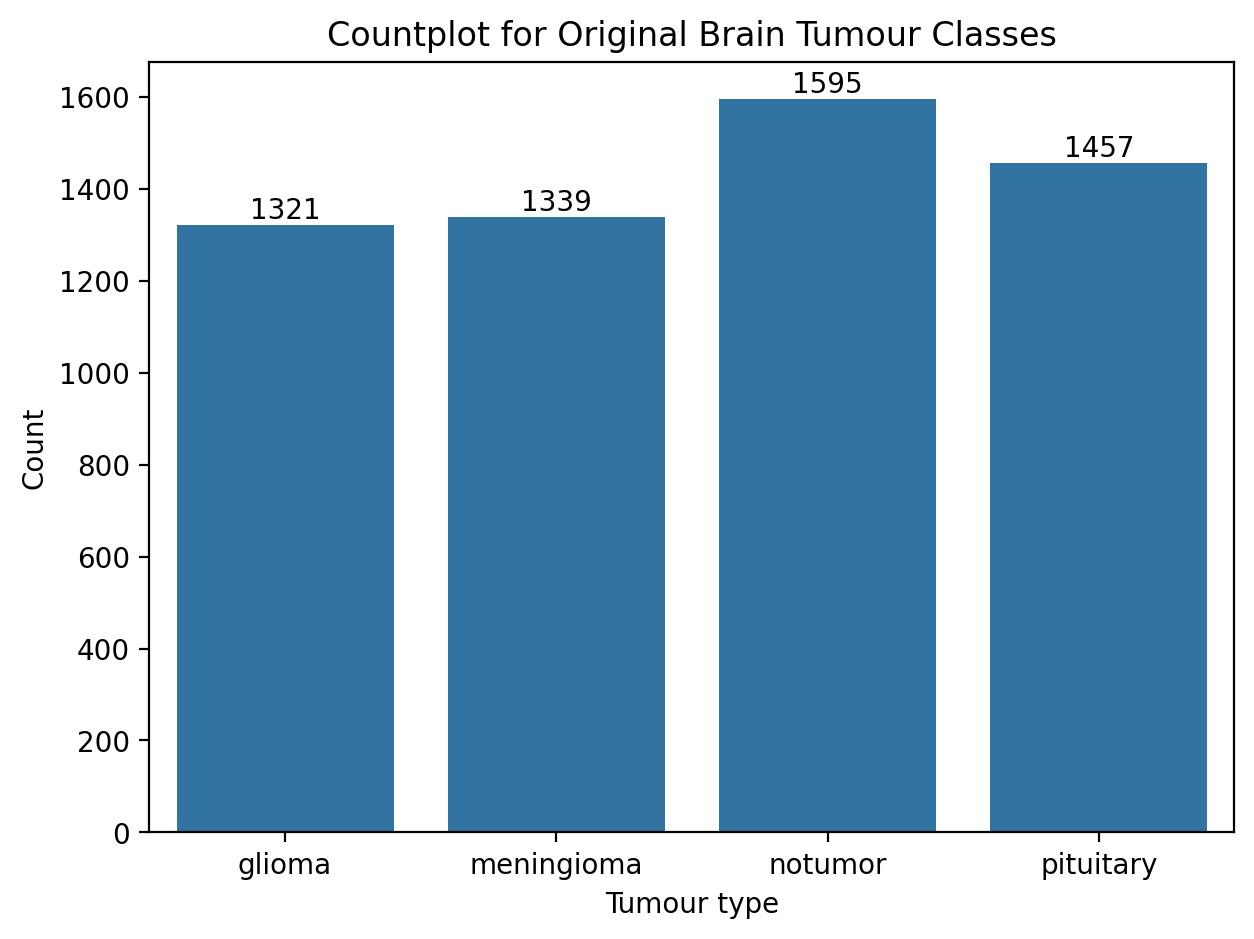

In [ ]:
# plot to see class counts for training data

# set plot size
plt.figure(figsize = (7,5))

# plot graph
graph = sns.countplot(train_df, x = "labels")

# get the number of count in the graphs
for label in graph.containers:
  graph.bar_label(label)

# graph titles and axes labels
plt.title("Countplot for Original Brain Tumour Classes")
plt.ylabel("Count")
plt.xlabel("Tumour type")

plt.show;

**Insights:**

Based on the original dataset, we can see that the 4 classes contain different number of images. We will proceed to balance them out by following the lowest number of images - 1321.

In [ ]:
tf.keras.utils.set_random_seed(42)
# to randomly downsample the meningioma, notumor and pituitary classes to follow glioma class

# downsampling without replacement so that different images will be selected in a sample of 1321

# set the classes that we want to downsample in a list
high_sample_classes = ["meningioma", "notumor", "pituitary"]

# count the number of samples for each class
type_counts = train_df["labels"].value_counts()

# set the sample size that we want
class_size = 1321

# instantiate an empty dataframe to fit the newly sample classes
downsampled_df = pd.DataFrame()

for tumor_type in type_counts.index:
    if tumor_type in high_sample_classes:
      tumor = train_df[train_df["labels"] == tumor_type]
      downsampled_subset = resample(tumor,
                                    replace = False,  # downsample without replacement
                                    n_samples = class_size,
                                    random_state = 42)
      downsampled_df = pd.concat([downsampled_df, downsampled_subset])

# shuffle to randomise the row orders
downsampled_df = downsampled_df.sample(frac = 1, random_state = 42).reset_index(drop = True)

# combine with the original glioma class
glioma = train_df[train_df["labels"] =="glioma"]
train_df_balanced = pd.concat([glioma, downsampled_df], ignore_index = True)


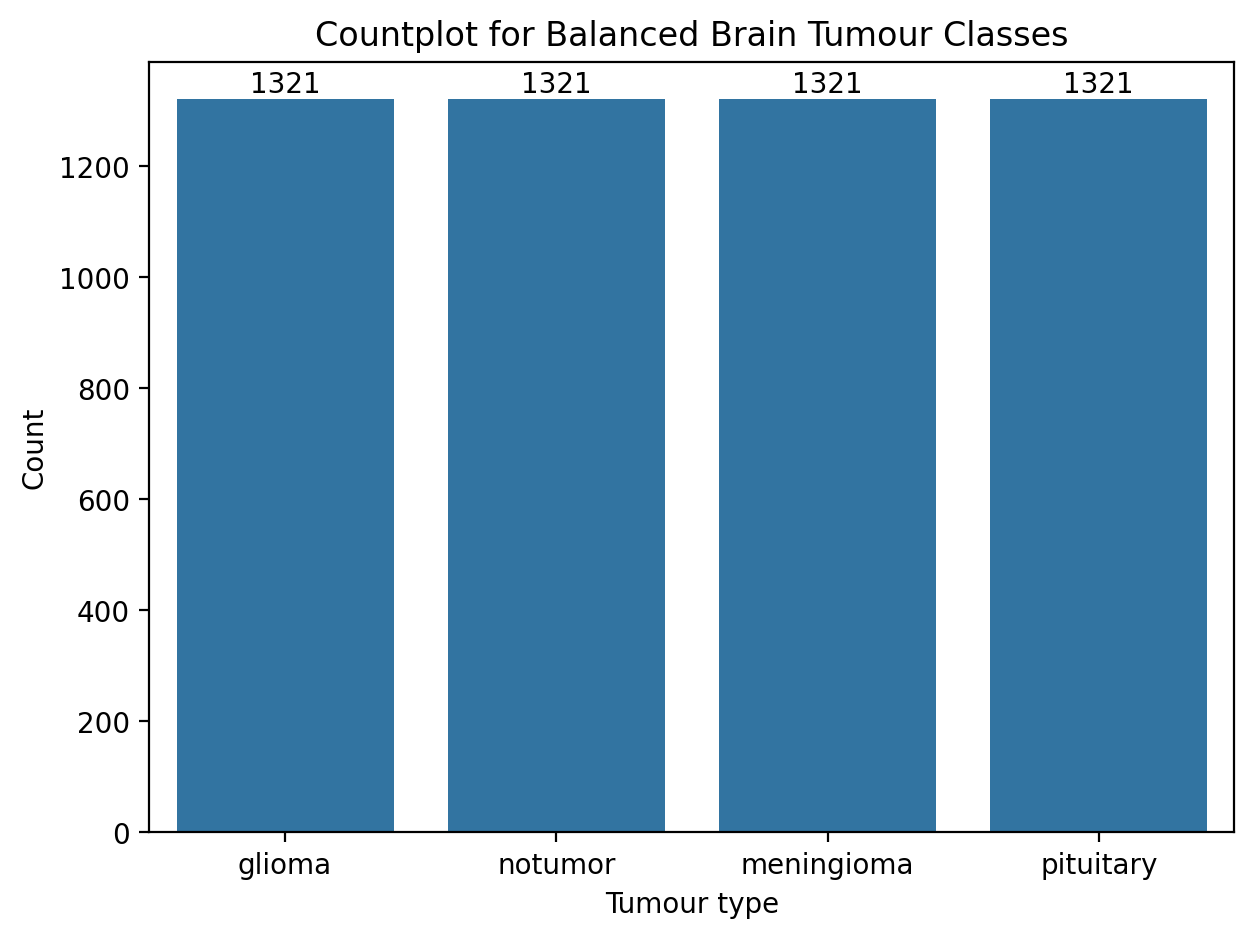

In [ ]:
# plot the newly balanced data

# set plot size
plt.figure(figsize = (7,5))

# plot graph
graph_new = sns.countplot(train_df_balanced, x = "labels")

# get the number of count in the graphs
for label in graph_new.containers:
  graph_new.bar_label(label)

# graph titles and axes labels
plt.title("Countplot for Balanced Brain Tumour Classes")
plt.ylabel("Count")
plt.xlabel("Tumour type")

plt.show;


**Summary:**

To ensure that the pretrained models will train well on 4 different classes, we have balanced out each class to have the same number of images.

<b> Validation data (val_df) </b>

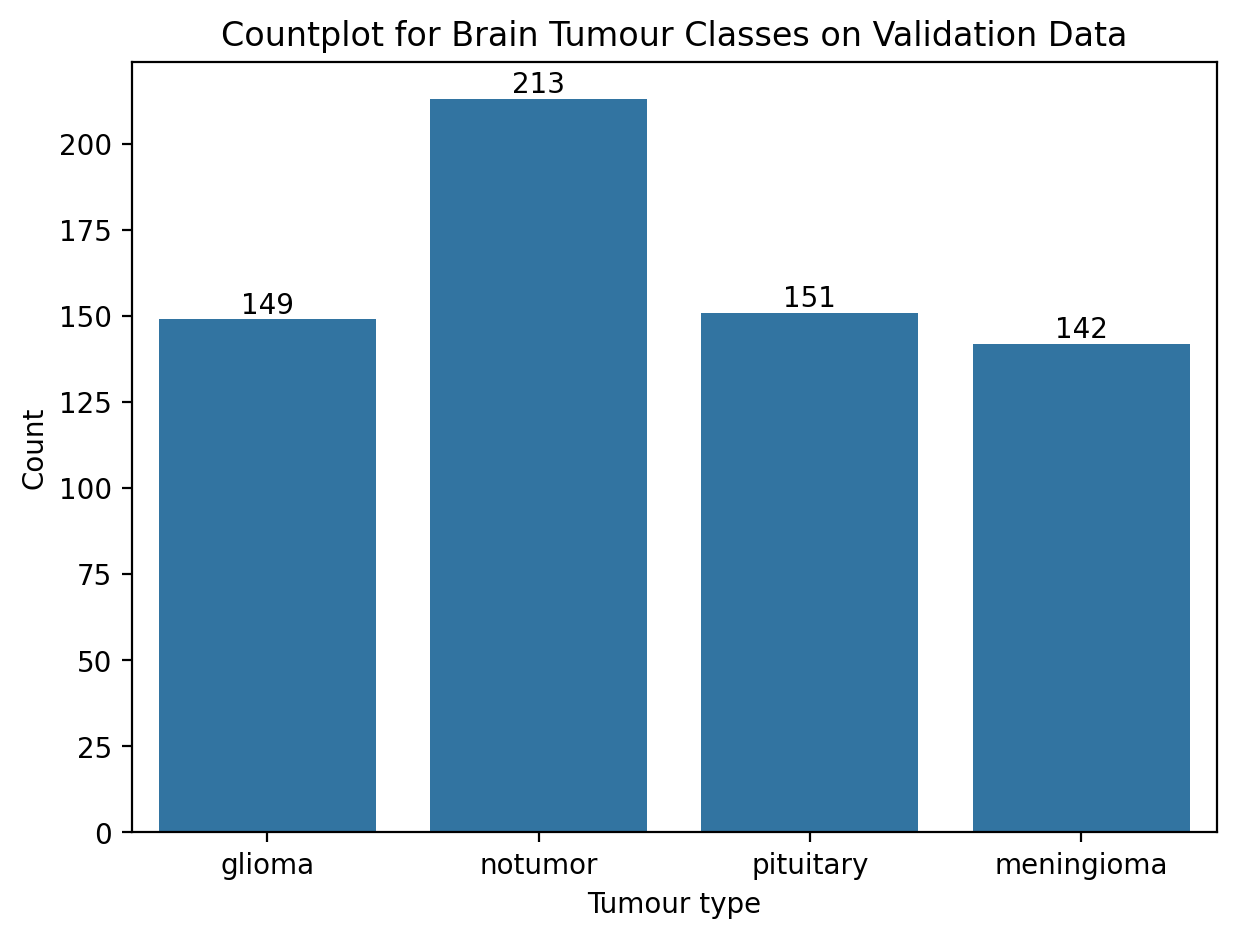

In [ ]:
# plot to see class counts for validation data

# set plot size
plt.figure(figsize = (7,5))

# plot graph
graph_val = sns.countplot(val_df, x = "labels")
# get the number of count in the graphs
for label in graph_val.containers:
  graph_val.bar_label(label)

# graph titles and axes labels
plt.title("Countplot for Brain Tumour Classes on Validation Data")
plt.ylabel("Count")
plt.xlabel("Tumour type")

plt.show;

**Summary:**

Even though there are slight differences in each class, most of them are more or less the same. We will leave the number of images in each class alone as they are used for validation later on and not for training.

### Part 3: Image preprocessing

We will use `flow_from_dataframe` which is available in Keras to normalize our images. `ImageDataGenerator` helps us to augment our images - the default setting will randomly transform the images so that it adds variation to our images during model training.

In [ ]:
tf.keras.utils.set_random_seed(42)

# setting the image size to use imagedatagenerator on
# for VGG16, ResNet50 requires 224 x 224
image_size = (224, 244)

# set the batch size
# this number should be divisible by the number of images in our train, val and test set
# especially important for the testing data
batch_size = 16

# instantiate imagedatagenerator for each of the 3 data (train, val and test)
tr_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df_balanced, x_col = "filepaths", y_col = "labels", target_size = image_size, seed = 42,
                                          class_mode = "categorical", color_mode = "rgb", shuffle = True, batch_size = batch_size)

valid_gen = val_gen.flow_from_dataframe(val_df, x_col = "filepaths", y_col = "labels", target_size = image_size, seed = 42,
                                             class_mode = "categorical", color_mode = "rgb", shuffle = True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(testing_df , x_col = "filepaths" , y_col = "labels", target_size = image_size, seed = 42,
                                        class_mode = "categorical", color_mode= "rgb" , shuffle = False , batch_size = batch_size) # note: shuffle = False for testing data

Found 5284 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


<b> Visualizing the images after augmentation on data</b>

In [ ]:
# create a function for image normalization & visualization

def norm_image(df):
  # .class_indices defines dictionary {"class": index} from keras - default format
  class_labels = df.class_indices

  # get the keys of the class_labels in a list
  list_class_labels = list(class_labels.keys())

  # gets the image size, batch size from the generator
  images, labels = next(df)

  # set plot size to see augmented images
  plt.figure(figsize = (16, 16))

  # plot images
  # plot in 3x3 fashion, total 16 images
  for i in range(9):
    plt.subplot(3, 3, i + 1)

    # normalise each image - divide by 255 pixels
    # plt.imshow to display image
    image = images[i] / 255
    plt.imshow(image)

    # get image index
    index = np.argmax(labels[i])

    # get name of the image from our list of keys
    class_name = list_class_labels[index]
    plt.title(class_name, color = "black", fontsize = 14)
    plt.axis("off")

  plt.tight_layout()
  plt.show();

  return

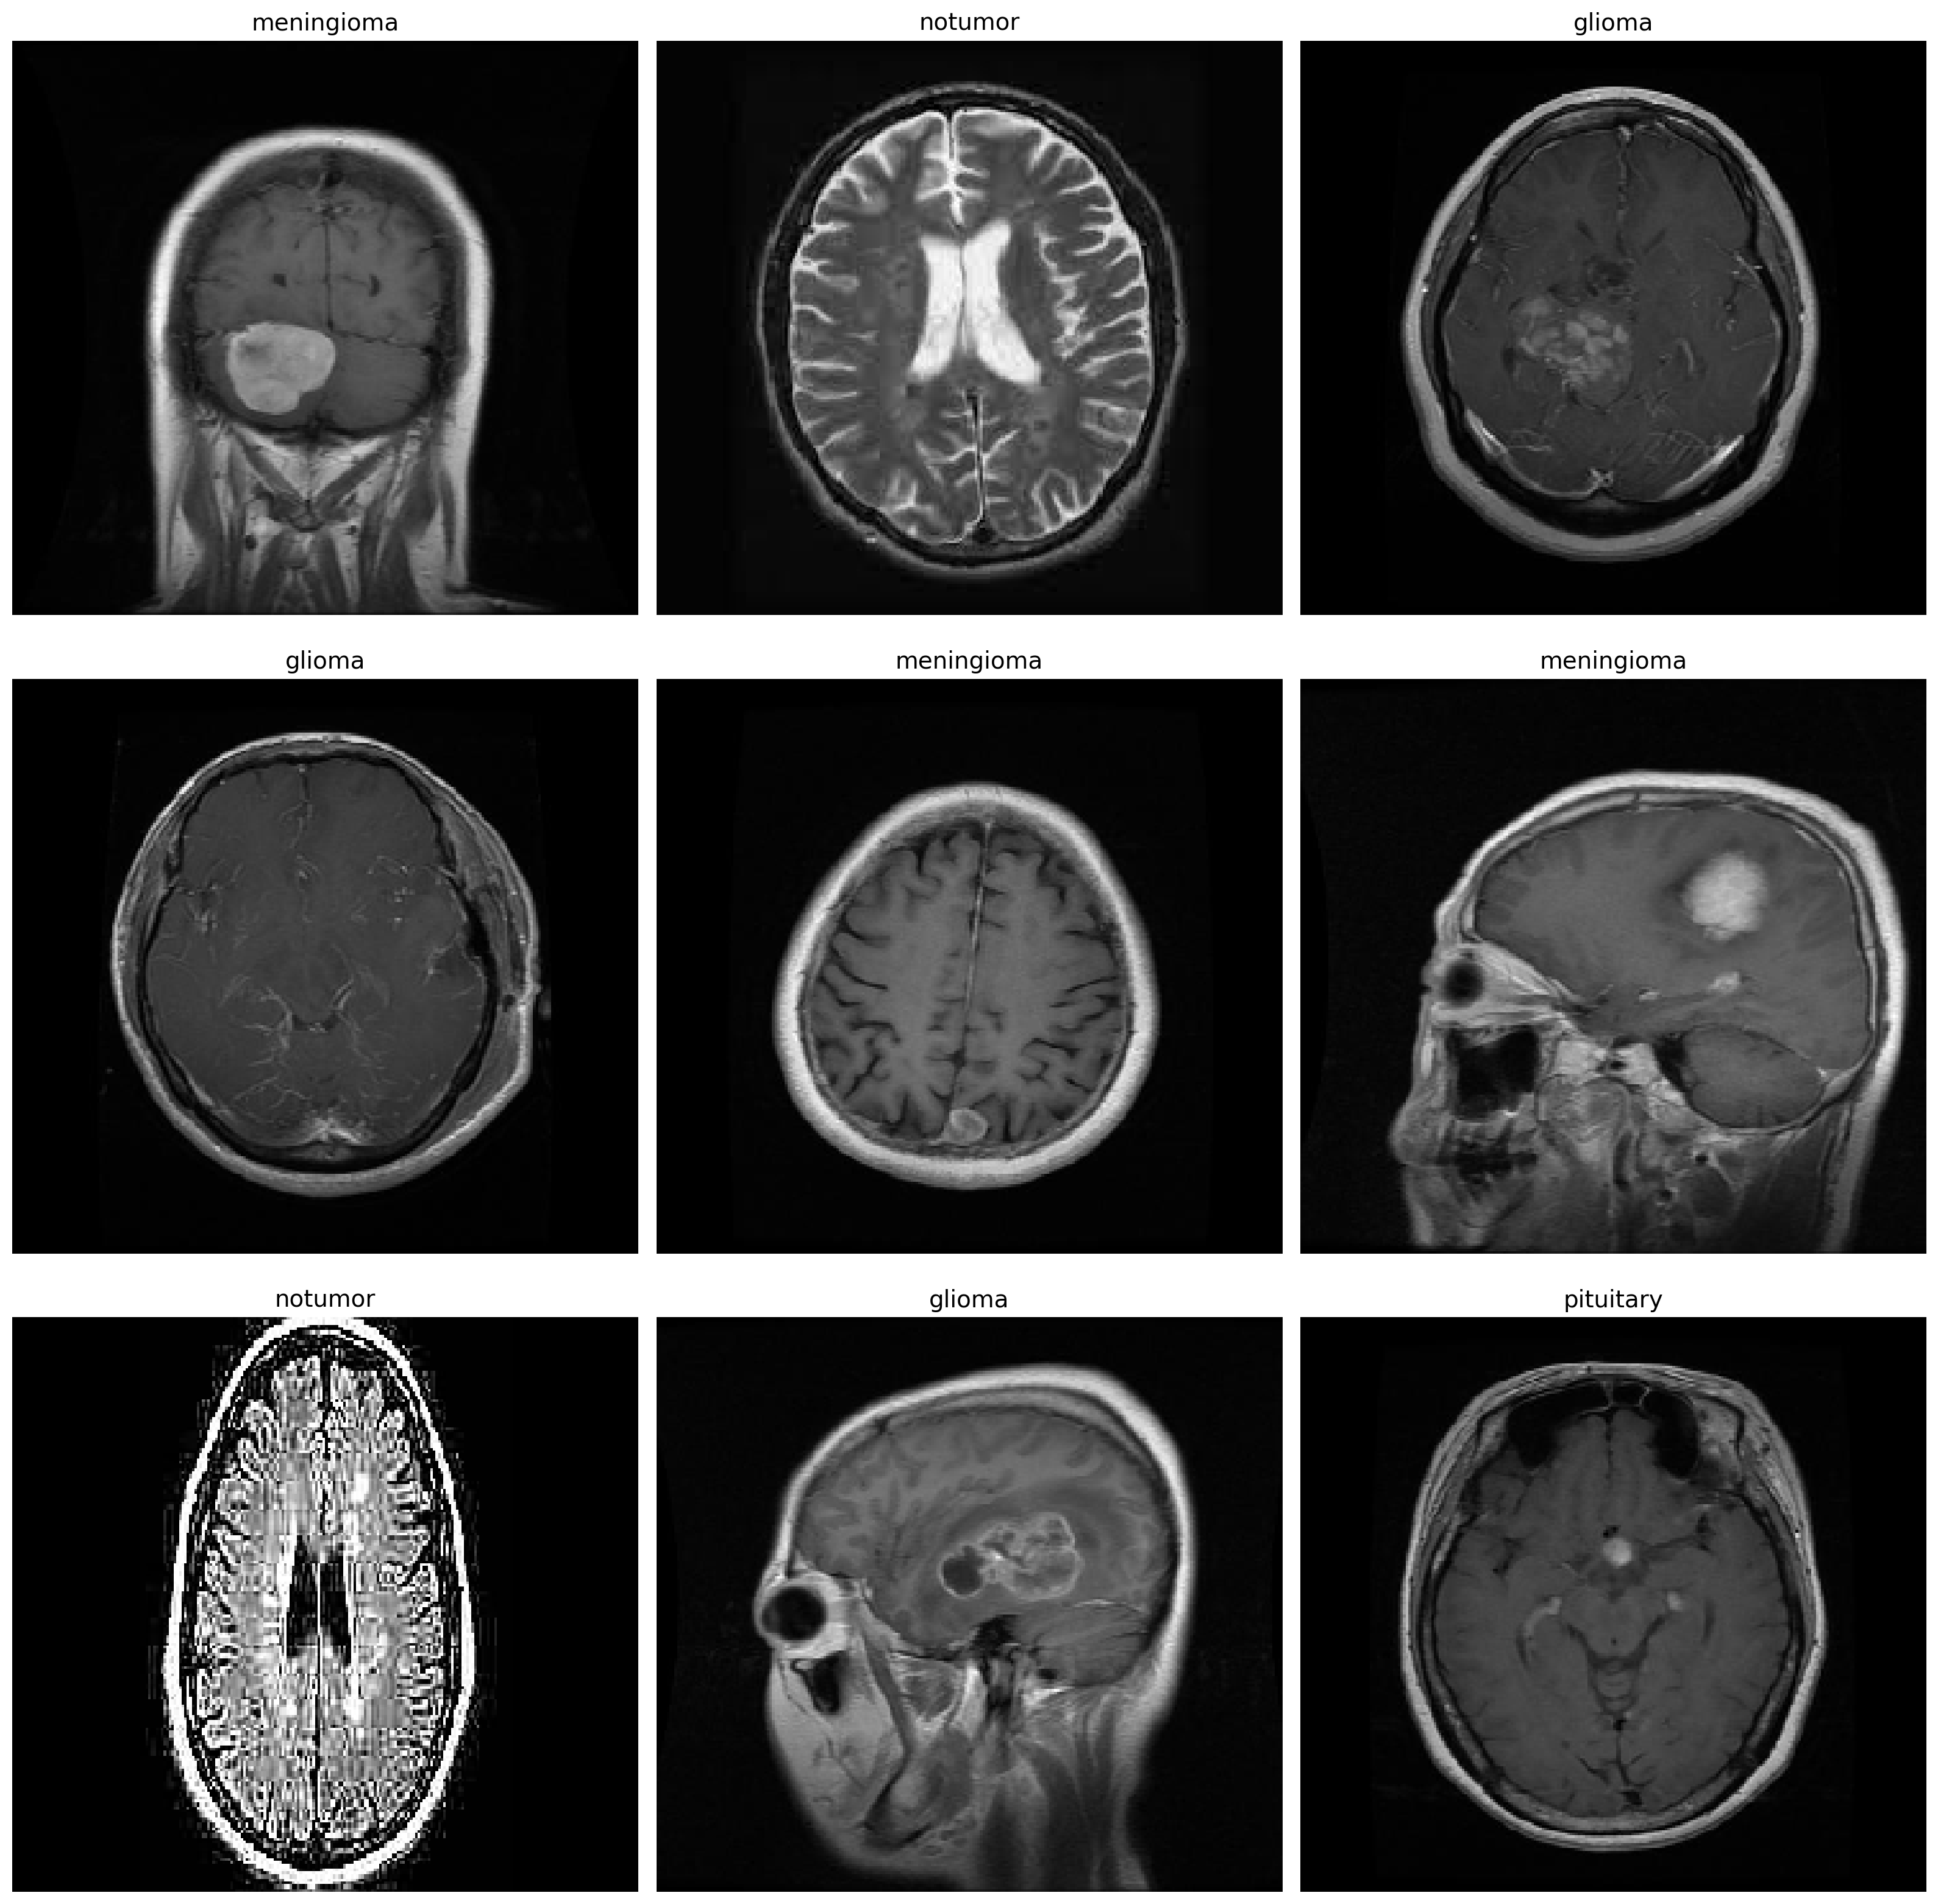

In [ ]:
# invoke the function on train_gen
norm_image(train_gen)

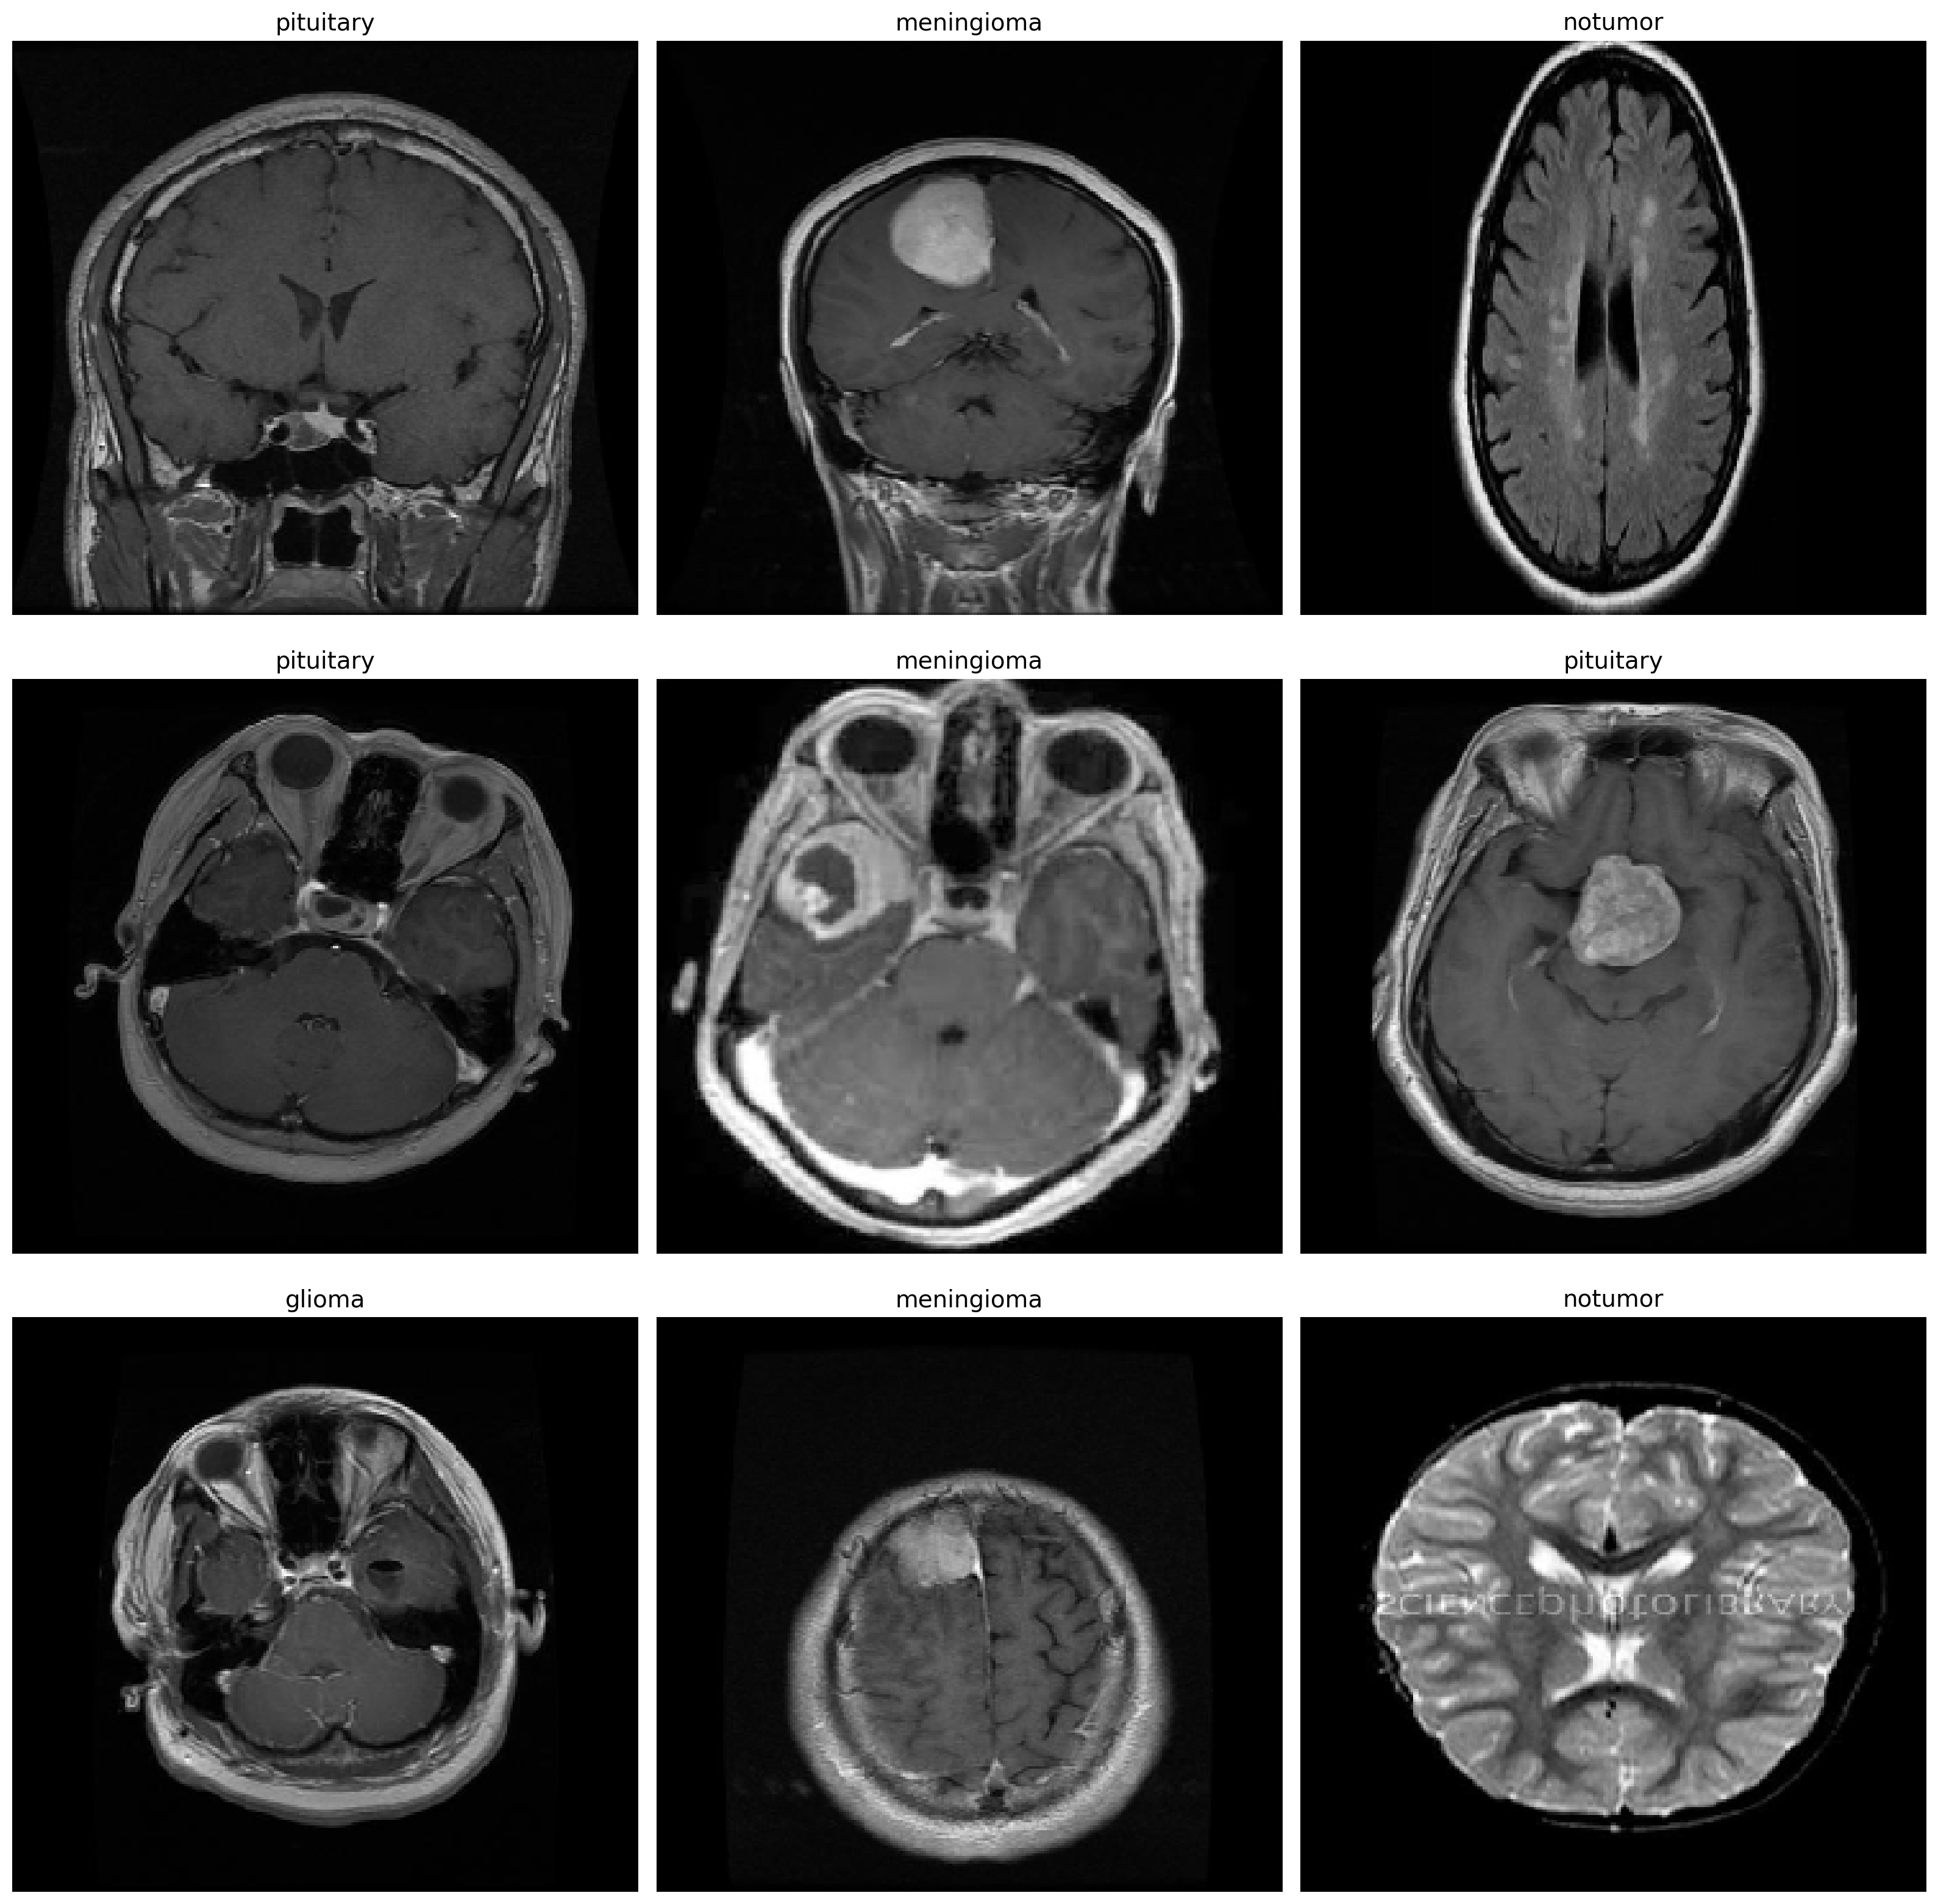

In [ ]:
# invoke the function on val_gen
norm_image(valid_gen)

### Part 4: Modelling & Metric Tracking

We will attempt to use VGG16, ResNet50, EfficientNetB2 to train on our dataset.

VGG16 and ResNet50 are tried and tested methods on medical imaging classification in general(https://www.frontiersin.org/articles/10.3389/fnhum.2023.1150120/full). However EfficientNetB2 is seldom used and only tested on the figshare dataset, which only forms part of the current dataset that we are using (https://www.sciencedirect.com/science/article/abs/pii/S1746809423002100).

### (a) VGG16

First we will instantiate the pre-trained model to take a closer look at the architecture to decide what we want to keep and remove as well as check the input shape required.

In [ ]:
# instantiate vgg16 model (pre-trained)
vgg16 = VGG16()

# see model summary
print(vgg16.summary())

553467096/553467096 [==============================] - 15s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

**Insights:**

Based on the model summary, it needs a (244, 244, 3) shape on our images for it to work. However the final output is 1000 whereas in our case we only need 4 outputs. We will need to use `include_top = False` and add our own dense layers instead of the pre-trained model. We will still use the pretrained weights of the pre-trained model - hence we will need to freeze the rest of the architecture.

<b>Version 1:</b>

We will follow exactly the same as the pre-trained model architecture after block 5 and only change the last layer to 4 outputs with softmax instead of 1000 outputs with softmax.

In [ ]:
# instantiate the model that we want to use
# activate include_top = False  - we do not want the last layer - we will customise it
# we will use weights from imagenet

image_shape = (224, 224, 3)
base_vgg16 = VGG16(include_top = False, weights = "imagenet", input_shape = image_shape)

# freeze all the other layers so we don't accidentally change the pre-trained model parameters
for layer in base_vgg16.layers:
  layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# create an empty nn model
model_vgg16 = Sequential()

# add the vgg16 original architecture in without the top layer
model_vgg16.add(base_vgg16)
model_vgg16.add(Flatten(name = "flatten"))

# add in our dense layers to get a fully connected layer
# we follow the dense layers as 4096 as per VGG16 original and drop by half on the next layer to reduce computational usage
# but we need to switch the last layer to 4 outputs
model_vgg16.add(Dense(units = 4096, activation = "relu"))
model_vgg16.add(Dense(units = 1026, activation = "relu"))
model_vgg16.add(Dense(units = 4, activation = "softmax"))

In [ ]:
# compile the model with the loss, optimiser and metrics

# set the optimiser at a very low learning rate to not disrupt the weights of the original pretrained model
opt = Adam(learning_rate = 0.001)

model_vgg16.compile(loss = "categorical_crossentropy",
                  optimizer = opt,
                  metrics = ["accuracy"])

# check the new summary of our model
model_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              102764544 
                                                                 
 dense_2 (Dense)             (None, 1026)              4203522   
                                                                 
 dense_3 (Dense)             (None, 4)                 4108      
                                                                 
Total params: 121686862 (464.20 MB)
Trainable params: 106972174 (408.07 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


<b> Training the model </b>

In [ ]:
# fit in the training data
%%time
tf.keras.utils.set_random_seed(42)

vgg_history = model_vgg16.fit(x = train_gen, epochs = 30,
                                         validation_data = valid_gen, batch_size = 64,
                                         steps_per_epoch = 82, validation_steps = 10, verbose = 1)

Epoch 1/30
82/82 [==============================] - 647s 8s/step - loss: 28.4941 - accuracy: 0.7392 - val_loss: 1.9571 - val_accuracy: 0.8250
Epoch 2/30
82/82 [==============================] - 491s 6s/step - loss: 1.5320 - accuracy: 0.8445 - val_loss: 0.7534 - val_accuracy: 0.8750
Epoch 3/30
82/82 [==============================] - 345s 4s/step - loss: 0.4768 - accuracy: 0.9108 - val_loss: 0.7121 - val_accuracy: 0.8562
Epoch 4/30
82/82 [==============================] - 277s 3s/step - loss: 0.6777 - accuracy: 0.8941 - val_loss: 1.3569 - val_accuracy: 0.8500
Epoch 5/30
82/82 [==============================] - 186s 2s/step - loss: 0.6475 - accuracy: 0.8892 - val_loss: 0.5821 - val_accuracy: 0.9062
Epoch 6/30
82/82 [==============================] - 148s 2s/step - loss: 0.3469 - accuracy: 0.9413 - val_loss: 0.2259 - val_accuracy: 0.9375
Epoch 7/30
82/82 [==============================] - 110s 1s/step - loss: 0.2721 - accuracy: 0.9505 - val_loss: 0.3681 - val_accuracy: 0.9250
Epoch 8/30
8

<b> Version 2: Adding in a regularization technique </b>

We will add in early stopping for Version 2 to see if scores improve/ if they show us the same results as Version 1. We set mode to "min" so that training will stop once the val_loss stops decreasing.

In [ ]:
# setting the early stopping hyperparameters

early_stop = EarlyStopping(monitor = "val_loss",
                           patience = 5,
                           restore_best_weights = True,
                           mode = "min")

<b> Training the model </b>

In [ ]:
# fit in the training data with early_stopping
%%time
tf.keras.utils.set_random_seed(42)

vgg_history_2 = model_vgg16.fit(x = train_gen, epochs = 30,
                                         validation_data = valid_gen, batch_size = 64,
                                         steps_per_epoch = 82, validation_steps = 10,
                                         callbacks = [early_stop], verbose = 1)

Epoch 1/30
82/82 [==============================] - 12s 140ms/step - loss: 0.0750 - accuracy: 0.9854 - val_loss: 0.5368 - val_accuracy: 0.9375
Epoch 2/30
82/82 [==============================] - 10s 126ms/step - loss: 0.1087 - accuracy: 0.9863 - val_loss: 0.6122 - val_accuracy: 0.9500
Epoch 3/30
82/82 [==============================] - 11s 133ms/step - loss: 0.0631 - accuracy: 0.9886 - val_loss: 0.7228 - val_accuracy: 0.9375
Epoch 4/30
82/82 [==============================] - 11s 131ms/step - loss: 0.1270 - accuracy: 0.9817 - val_loss: 0.2544 - val_accuracy: 0.9750
Epoch 5/30
82/82 [==============================] - 10s 122ms/step - loss: 0.0703 - accuracy: 0.9862 - val_loss: 0.5241 - val_accuracy: 0.9375
Epoch 6/30
82/82 [==============================] - 10s 125ms/step - loss: 0.1025 - accuracy: 0.9848 - val_loss: 0.3015 - val_accuracy: 0.9312
Epoch 7/30
82/82 [==============================] - 10s 123ms/step - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.0996 - val_accuracy: 0.9688

<b> Version 3: Changing the optimiser </b>

We will change the customised model's optimiser from Adam to RMSProp to see if it works better with early stopping.

In [ ]:
# create an empty nn mode
model_vgg16_2 = Sequential()

# exact same structure as Version 1
model_vgg16_2.add(base_vgg16)
model_vgg16_2.add(Flatten(name = "flatten"))
model_vgg16_2.add(Dense(units = 4096, activation = "relu"))
model_vgg16_2.add(Dense(units = 1026, activation = "relu"))
model_vgg16_2.add(Dense(units = 4, activation = "softmax"))

# set the optimiser at a very low learning rate to not disrupt the weights of the original pretrained model
opt_2 = RMSprop(learning_rate = 0.001)

model_vgg16_2.compile(loss = "categorical_crossentropy",
                  optimizer = opt_2,
                  metrics = ["accuracy"])

# check the new summary of our model
model_vgg16_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 4096)              102764544 
                                                                 
 dense_5 (Dense)             (None, 1026)              4203522   
                                                                 
 dense_6 (Dense)             (None, 4)                 4108      
                                                                 
Total params: 121686862 (464.20 MB)
Trainable params: 106972174 (408.07 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


<b> Training the model </b>


In [ ]:
# fit in the training data with early_stopping and RMSprop optimizer
%%time
tf.keras.utils.set_random_seed(42)

vgg_history_3 = model_vgg16_2.fit(x = train_gen, epochs = 30,
                                         validation_data = valid_gen, batch_size = 64,
                                         steps_per_epoch = 82, validation_steps = 10,
                                         callbacks = [early_stop], verbose = 1)

Epoch 1/30
82/82 [==============================] - 13s 141ms/step - loss: 93.3894 - accuracy: 0.6408 - val_loss: 5.8935 - val_accuracy: 0.6938
Epoch 2/30
82/82 [==============================] - 11s 131ms/step - loss: 1.7456 - accuracy: 0.7995 - val_loss: 1.3433 - val_accuracy: 0.7688
Epoch 3/30
82/82 [==============================] - 12s 142ms/step - loss: 0.8694 - accuracy: 0.8438 - val_loss: 0.9419 - val_accuracy: 0.8562
Epoch 4/30
82/82 [==============================] - 10s 126ms/step - loss: 0.5512 - accuracy: 0.8727 - val_loss: 0.7958 - val_accuracy: 0.8375
Epoch 5/30
82/82 [==============================] - 10s 120ms/step - loss: 0.4471 - accuracy: 0.8931 - val_loss: 0.2803 - val_accuracy: 0.9125
Epoch 6/30
82/82 [==============================] - 10s 123ms/step - loss: 0.4638 - accuracy: 0.8841 - val_loss: 0.3856 - val_accuracy: 0.9062
Epoch 7/30
82/82 [==============================] - 10s 125ms/step - loss: 0.3153 - accuracy: 0.9207 - val_loss: 0.3680 - val_accuracy: 0.906

<b> Plotting the accuracy and loss graphs </b>

In [ ]:
# create a function for curve plotting

def curve_plot(history):

  # 1. getting the loss values from .history
  train_loss_dropout = history.history["loss"]
  val_loss_dropout = history.history["val_loss"]
  index_loss = np.argmin(val_loss_dropout)
  val_lowest = val_loss_dropout[index_loss]
  loss_label = f"Best epoch = {str(index_loss + 1)}"


  # 2. getting the accuracy values from .history
  train_accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  index_acc = np.argmax(val_accuracy)
  val_highest = val_accuracy[index_acc]
  acc_label = f"Best epochs = {str(index_acc + 1)}"


  # 3. adjust for the fact that epoch starts from 1 while our data based on index usually starts at 0
  Epochs = [i+1 for i in range(len(train_accuracy))]


  # 4. set the plot size
  plt.figure(figsize = (12,4))
  plt.style.use("ggplot")


  # 5. LOSS GRAPH
  # plot graph for loss
  plt.subplot(1,2,1)
  plt.plot(Epochs, train_loss_dropout, label = "Training")
  plt.plot(Epochs, val_loss_dropout, label = "Validation")
  plt.scatter(index_loss + 1, val_lowest, s = 40, c = "black", label = loss_label)

  # graph title and axes labels
  plt.title("Training vs Validation Loss")
  plt.ylim(0, 4)
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend()


  # 6. ACCURACY GRAPH
  # plot graph for accuracy
  plt.subplot(1,2,2)
  plt.plot(Epochs, train_accuracy, label = "Training")
  plt.plot(Epochs, val_accuracy, label = "Validation")
  plt.scatter(index_acc + 1, val_highest, s = 40, c = "black", label = acc_label)

  # graph title and axes labels
  plt.title("Training vs Validation Accuracy")
  plt.ylim(top = 1)
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend()

  plt.tight_layout
  plt.show()

  return

<b> Version 1 graphs </b>

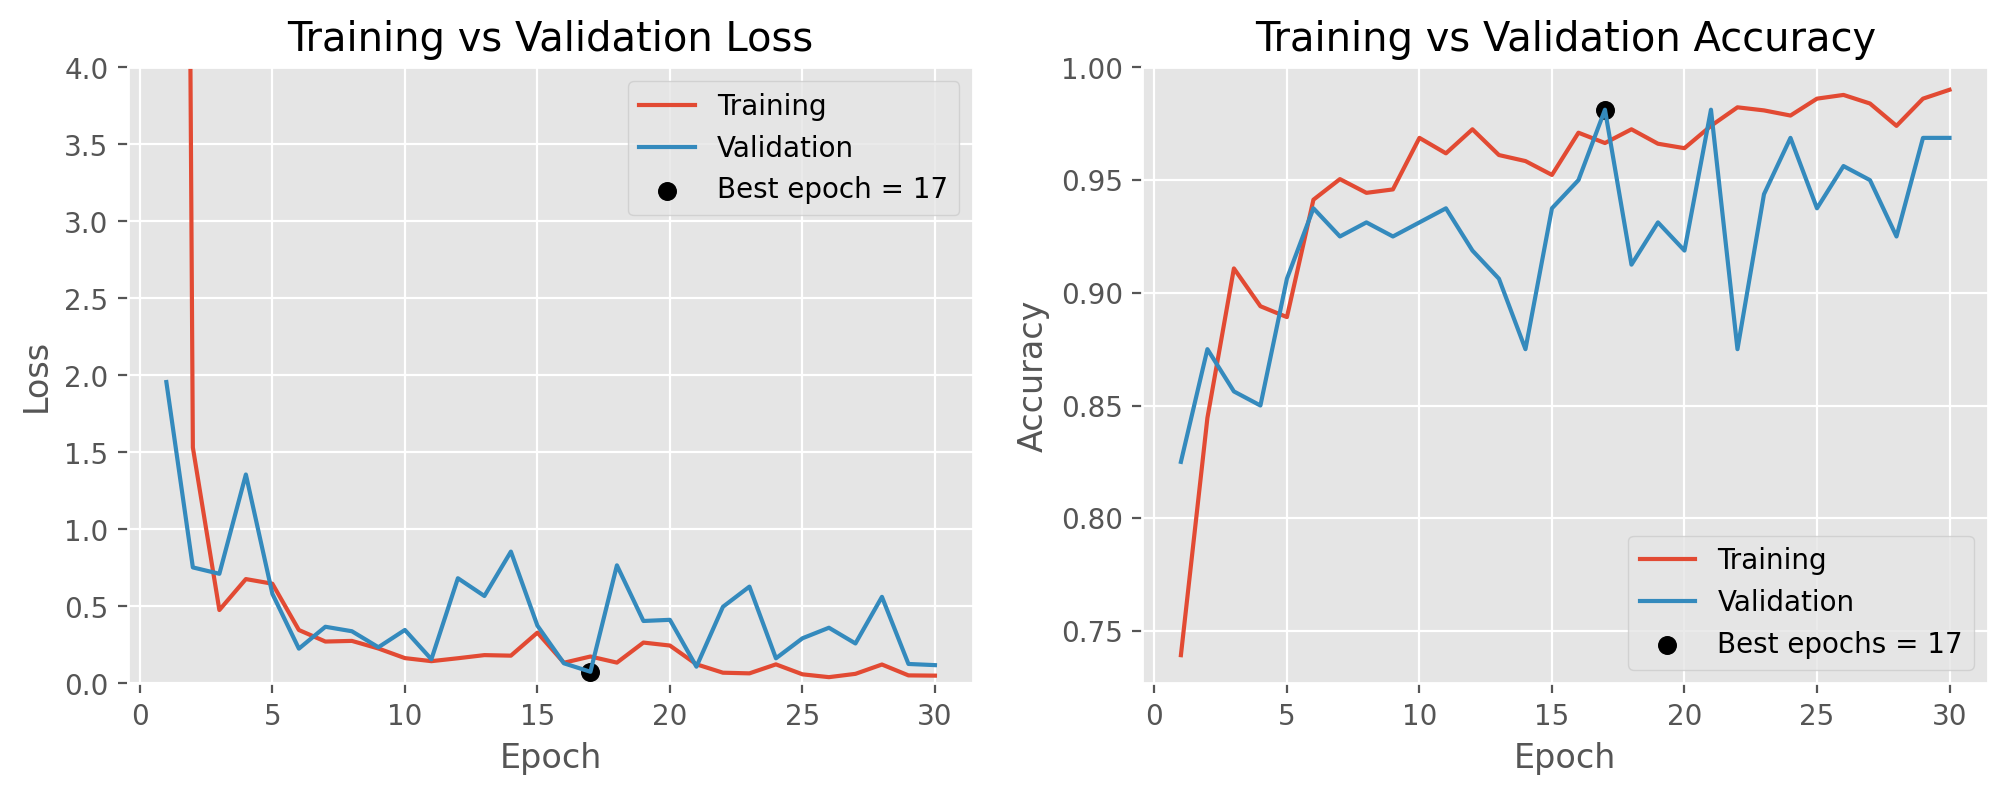

In [ ]:
curve_plot(vgg_history)

**Insights:**

Based on the above graphs, epoch 17 has the lowest loss and best accuracy.

epoch 17:
* loss: 0.1749
* val_loss: 0.0758
* accuracy: 0.9665
* val_accuracy: 0.9812

In this epoch, it is worth noting that validation data performed better than training data.

<b> Version 2 graphs </b>

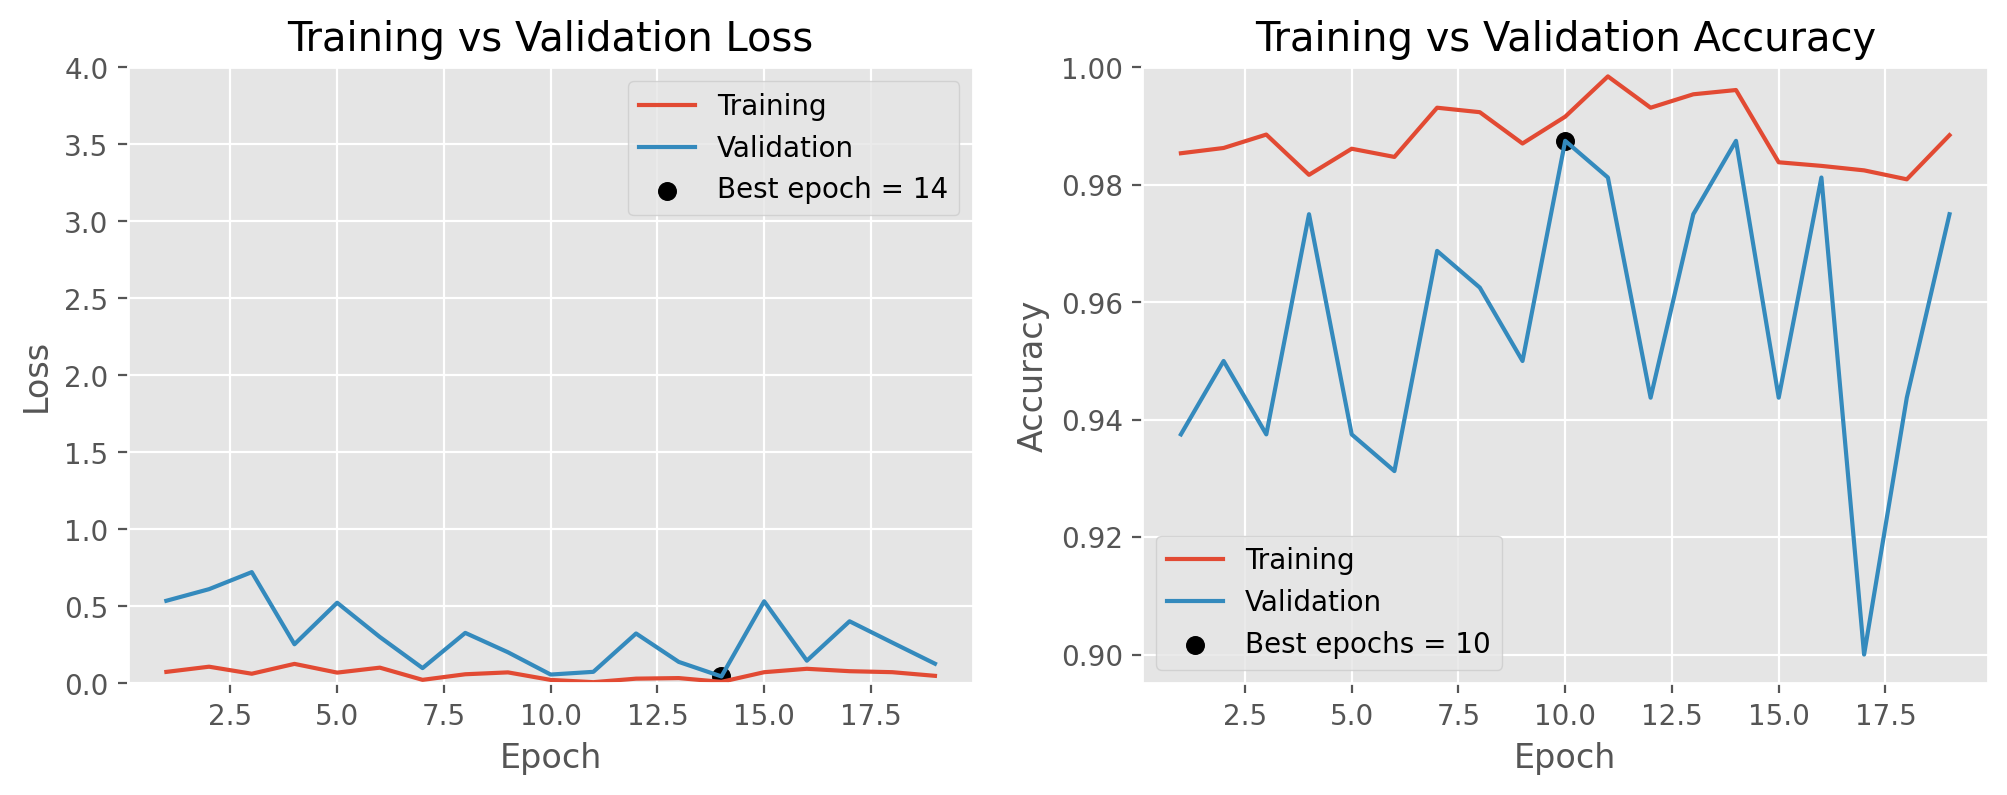

In [ ]:
curve_plot(vgg_history_2)

**Insights:**

Based on early stopping technique, the training stopped at epoch 19 out of 30 since the val loss did not get any smaller after 5 epochs (patience = 5).

The least loss occured at epoch 14
  * loss: 0.0103
  * val_loss: 0.0455

while the accuracy was the best on epoch 10.
  * accuracy: 0.9916
  * val_accuracy: 0.9875

However if we were to consider both's epoch's full scores as shown below, epoch 10's scores actually not too far off from epoch 14's.

  * Epoch 10: loss: 0.0230 - accuracy: 0.9916 - val_loss: 0.0577 - val_accuracy: 0.9875
    * Loss difference: 0.0347
    * Accuracy difference: 0.0041

  * Epoch 14: loss: 0.0103 - accuracy: 0.9962 - val_loss: 0.0455 - val_accuracy: 0.9875
    * Loss difference: 0.0352
    * Accuracy difference: 0.0087
  
  * If we were to conserve computing resources, training up to epoch 10 would probably be suffficiently good.



<b> Version 3 graphs </b>

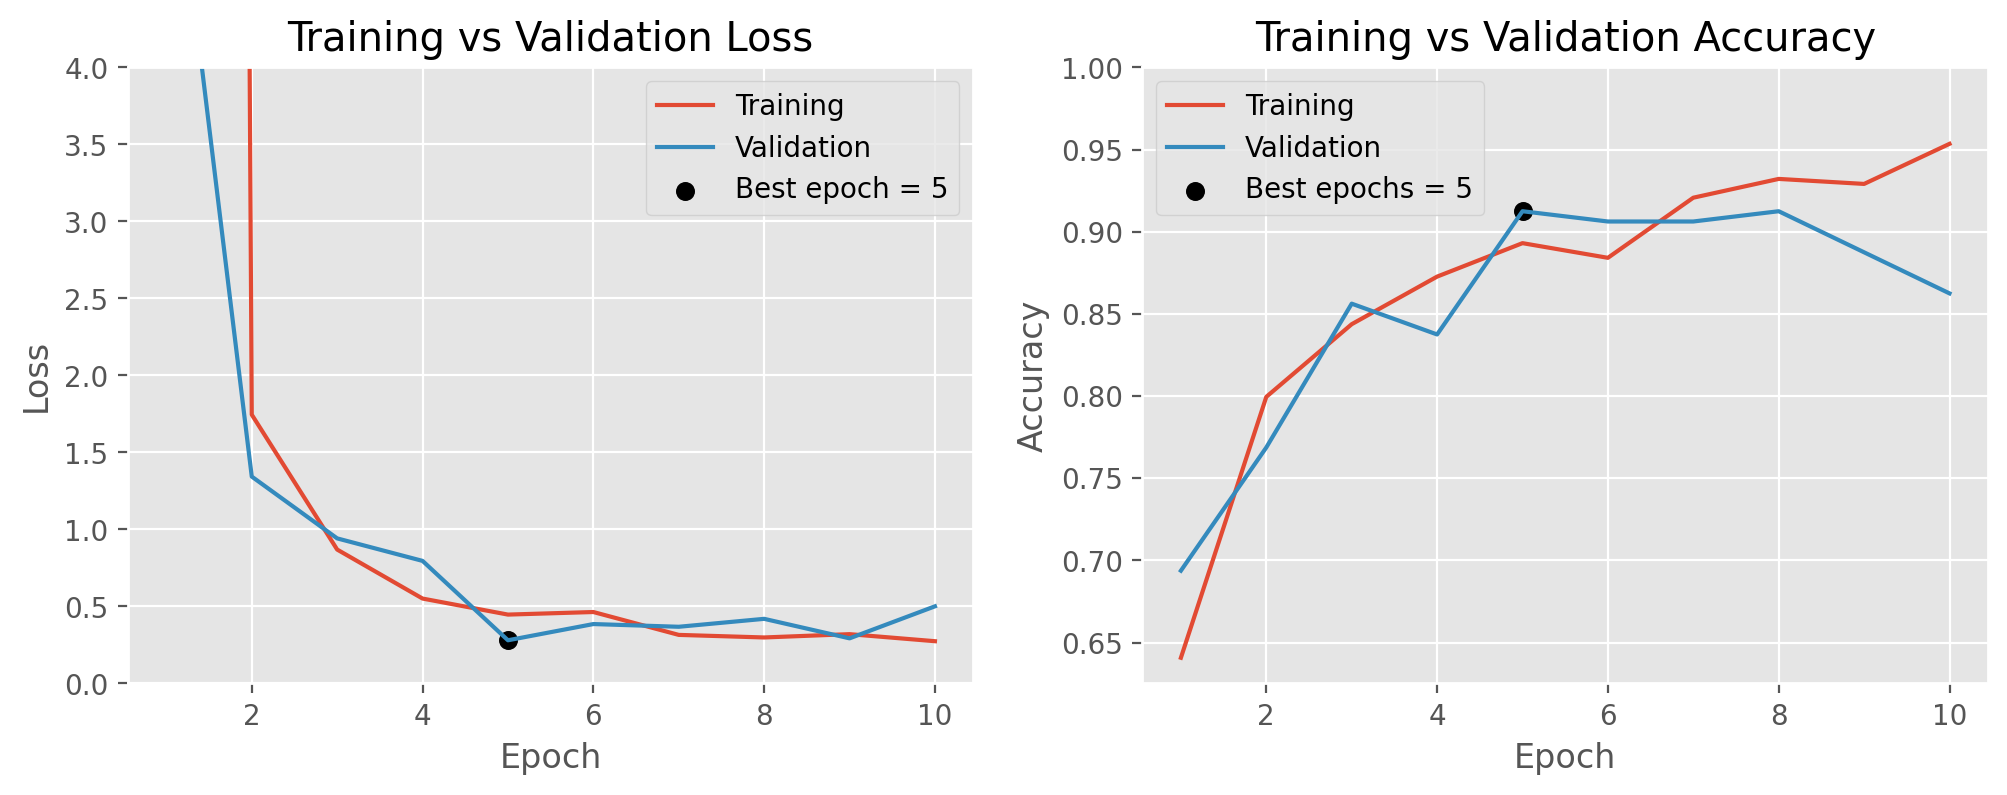

In [ ]:
curve_plot(vgg_history_3)

**Insights:**

Based on a RMSprop as an optimiser and the same early stopping hyperparameters used, the training stopped at epoch 10 out of 30.

Loss was least on epoch 5, where it performed better than training data
  * loss: 0.4471
  * val_loss: 0.2803

while accuracy was considered the best at same epoch as well.
  * accuracy: 0.8931
  * val_accuracy: 0.9125

<b> Model Evaluation on Testing data </b>

In [ ]:
# creating a function that will generate the confusion matrix on the testing dataset and classification report

def cm_report(model):
  # predicting an image
  preds = model.predict_generator(test_gen)
  y_preds = np.argmax(preds , axis = 1)

  # .class_indices defines dicionary for our test_gen
  test_labels = test_gen.class_indices

  # get the keys of test_labels into a list
  list_test_labels = list(test_labels.keys())

  # generate the confusion matrix
  cm = confusion_matrix(test_gen.classes, y_preds)


  # plot the confusion matrix
  # set the size of the plot
  plt.figure(figsize = (7, 7))

  # displays data as images
  plt.imshow(cm, interpolation = "nearest", cmap = "YlGn")
  plt.colorbar()

  # set the axes labels and title of plot
  plt.title("Confusion Matrix on Testing data")
  xaxis_labels = np.arange(len(list_test_labels))
  plt.xticks(xaxis_labels, list_test_labels, rotation = 90)
  plt.yticks(xaxis_labels, list_test_labels)

  # annotations for the cm
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "black")

  plt.tight_layout()
  plt.ylabel("True")
  plt.xlabel("Predicted")

  plt.show()

  # classification report
  print(classification_report(test_gen.classes, y_preds, target_names = list_test_labels))
  return

<b> 1. With Adam optimizer </b>

In [ ]:
tf.keras.utils.set_random_seed(42)

# Evaluate the loss and accuracy
loss, accuracy = model_vgg16.evaluate(test_gen)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

41/41 [==============================] - 219s 5s/step - loss: 0.5336 - accuracy: 0.9619
Accuracy: 0.9618902206420898
Loss: 0.5335915088653564


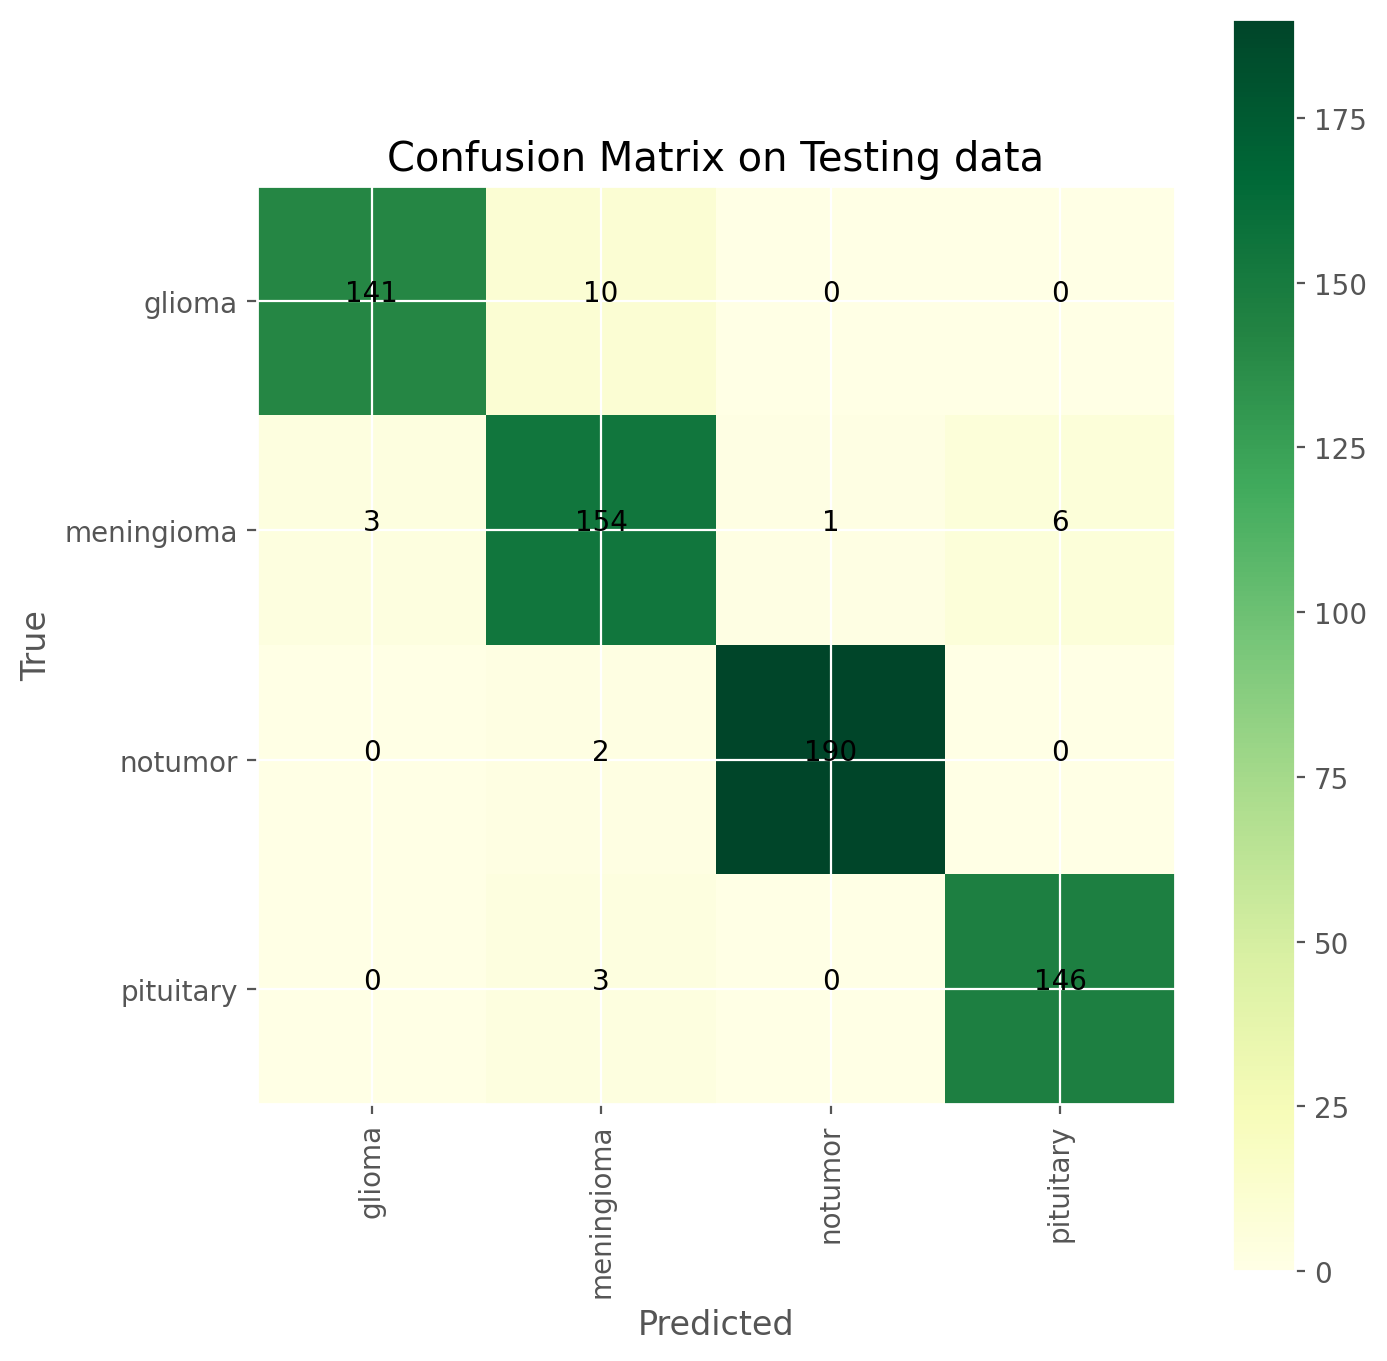

              precision    recall  f1-score   support

      glioma       0.98      0.93      0.96       151
  meningioma       0.91      0.94      0.92       164
     notumor       0.99      0.99      0.99       192
   pituitary       0.96      0.98      0.97       149

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656



In [ ]:
# invoke the function to plot cm
cm_report(model_vgg16)

<b> 2. With RMSprop optimizer </b>

In [ ]:
tf.keras.utils.set_random_seed(42)

# Evaluate the loss and accuracy
loss, accuracy = model_vgg16_2.evaluate(test_gen)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

41/41 [==============================] - 4s 92ms/step - loss: 0.4690 - accuracy: 0.8994
Accuracy: 0.8993902206420898
Loss: 0.46904972195625305


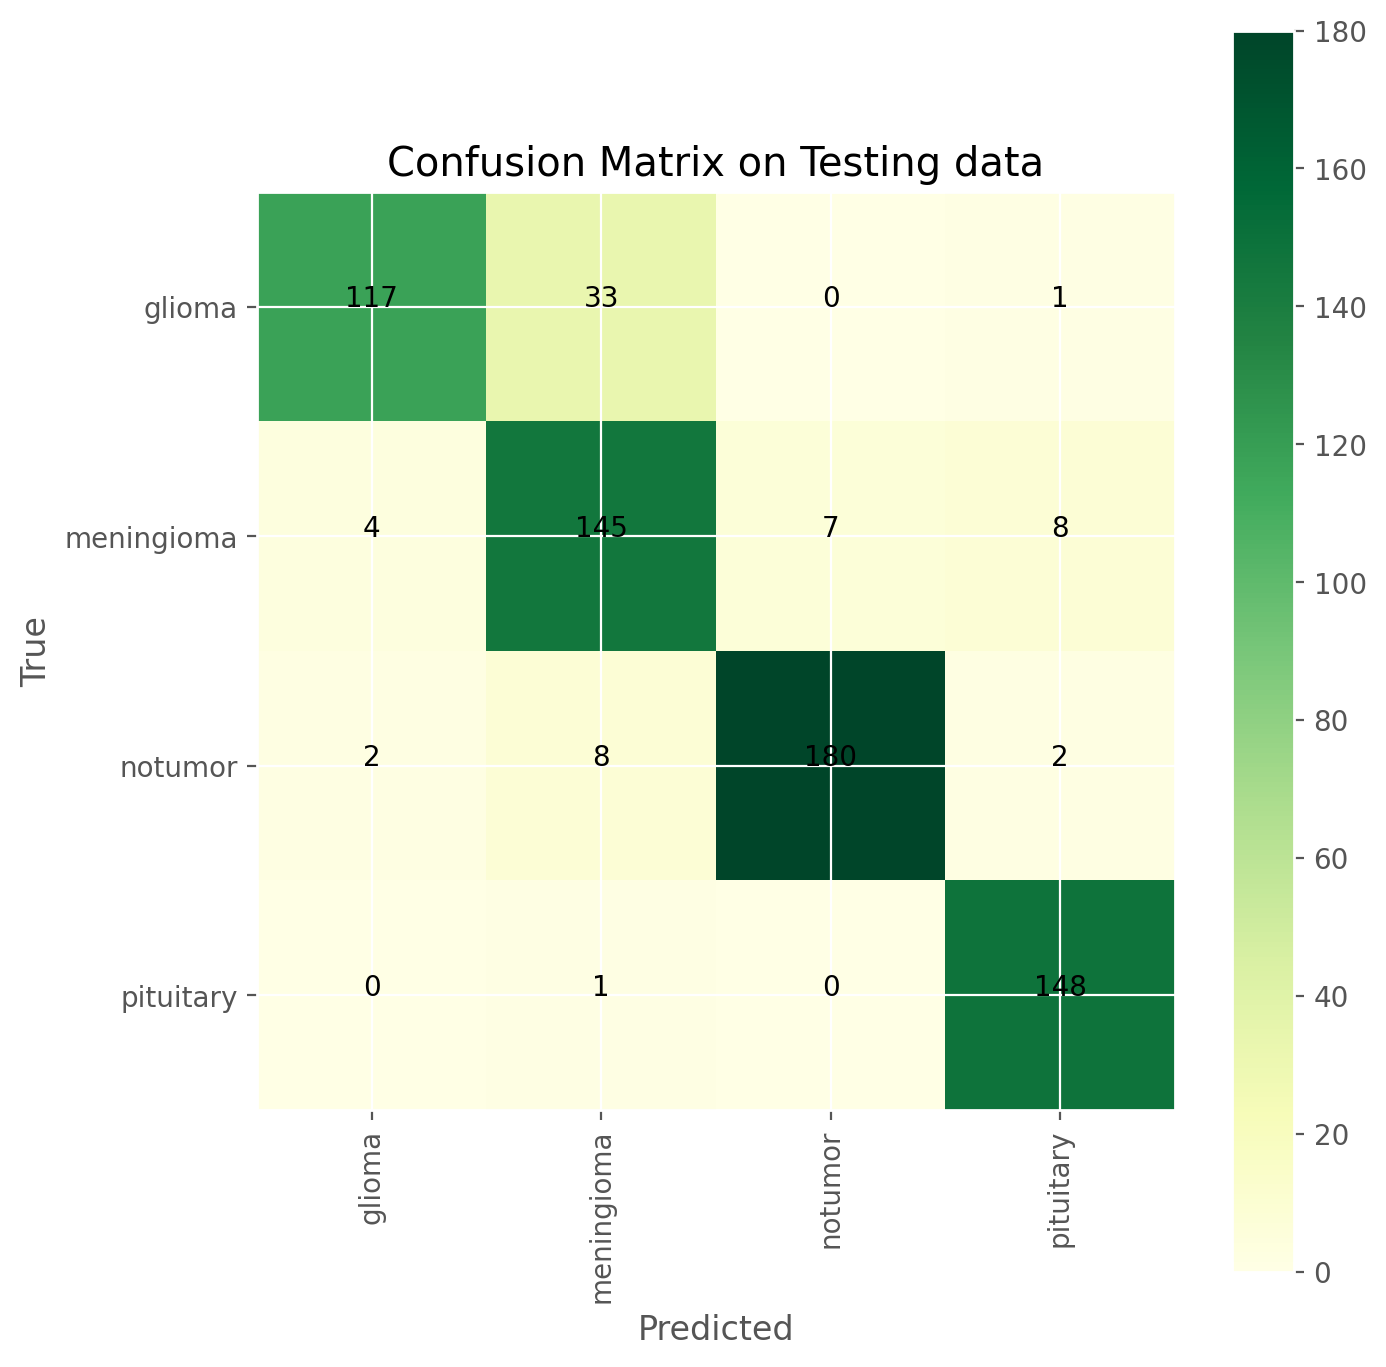

              precision    recall  f1-score   support

      glioma       0.95      0.77      0.85       151
  meningioma       0.78      0.88      0.83       164
     notumor       0.96      0.94      0.95       192
   pituitary       0.93      0.99      0.96       149

    accuracy                           0.90       656
   macro avg       0.91      0.90      0.90       656
weighted avg       0.91      0.90      0.90       656



In [ ]:
# invoke the function to plot cm
cm_report(model_vgg16_2)

### Summary for VGG16

The customised VGG16 models have generally good accuracy scores on validation data for all 3 versions. Adam optimiser models (Version 1 & 2) tend to reach a higher accuracy scores earlier than RMSprop model (Version 3).

Adam optimiser:
  * Accuracy: 0.962
  * Loss: 0.534

RMSprop optimiser:
  * Accuracy: 0.899
  * Loss: 0.469

Considering the classification report scores, the models were able to tell apart no tumors and pituitary quite well but struggles a little to distinguish meningioma vs glioma - which was expected as the appearance of both tumors are pretty similar on MRI; the Adam optimizer provided better overall scores for distinguishing the 4 lesions.

<br>

**Best model version for VGG16:**
VGG pretrained model using Adam optimiser (use early stopping)

---

### (b) ResNet50

Same as before, first we will instantiate the pre-trained model to take a closer look at the architecture to decide what we want to keep and remove as well as check the input shape required.

In [ ]:
# instantiate resnet50 model (pre-trained)
resnet = ResNet50()

# see model summary
print(resnet.summary())

102967424/102967424 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

**Insights:**

Based on the summary table, the input image have to have an input of (224, 224, 3). We will keep the original architecture up to conv_5 block (have to use `include_top = False` and freeze the layers).

<b> Version 1: </b>

We will customise the last layer for our brain dataset to 4 outputs intead of 1000. For ResNet50, note is taken that instead of `flatten`, it uses `global average pooling` instead.

In [ ]:
# instantiate the model that we want to use
# activate include_top = False  - we do not want the last layer - we will customise it
# we will use weights from imagenet

image_shape = (224, 224, 3)
base_resnet = ResNet50(include_top = False, weights = "imagenet", input_shape = image_shape)

# freeze all the other layers so we don't accidentally change the pre-trained model parameters
for layer in base_resnet.layers:
  layer.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# create an empty nn model
model_resnet = Sequential()

# add the resnet original architecture in without the top layer
model_resnet.add(base_resnet)

# add in our dense layers to get a fully connected layer
# but we need to switch the last layer to 4 outputs
model_resnet.add(GlobalAveragePooling2D())
model_resnet.add(Dense(units = 4, activation = "softmax"))

# compile the model with the loss, optimiser and metrics
# set the optimiser at a very low learning rate to not disrupt the weights of the original pretrained model
opt = Adam(learning_rate = 0.001)

model_resnet.compile(loss = "categorical_crossentropy",
                  optimizer = opt,
                  metrics = ["accuracy"])

# check the new summary of our model
model_resnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


<b> Training the model </b>

In [ ]:
# fit in the training data
%%time
tf.keras.utils.set_random_seed(42)

resnet_history = model_resnet.fit(x = train_gen, epochs = 30,
                                         validation_data = valid_gen, batch_size = 64,
                                         steps_per_epoch = 82, validation_steps = 10, verbose = 1)

Epoch 1/30
82/82 [==============================] - 17s 140ms/step - loss: 0.7261 - accuracy: 0.7062 - val_loss: 0.4027 - val_accuracy: 0.8625
Epoch 2/30
82/82 [==============================] - 10s 116ms/step - loss: 0.3623 - accuracy: 0.8750 - val_loss: 0.4909 - val_accuracy: 0.8313
Epoch 3/30
82/82 [==============================] - 9s 111ms/step - loss: 0.3201 - accuracy: 0.8872 - val_loss: 0.3876 - val_accuracy: 0.8562
Epoch 4/30
82/82 [==============================] - 10s 117ms/step - loss: 0.2892 - accuracy: 0.8925 - val_loss: 0.3837 - val_accuracy: 0.8438
Epoch 5/30
82/82 [==============================] - 11s 132ms/step - loss: 0.2719 - accuracy: 0.8962 - val_loss: 0.2410 - val_accuracy: 0.9125
Epoch 6/30
82/82 [==============================] - 9s 108ms/step - loss: 0.2284 - accuracy: 0.9223 - val_loss: 0.2786 - val_accuracy: 0.9125
Epoch 7/30
82/82 [==============================] - 10s 119ms/step - loss: 0.2195 - accuracy: 0.9238 - val_loss: 0.2633 - val_accuracy: 0.8938
E

<b> Version 2: Adding in a regularization technique </b>

We will add in early stopping for Version 2. For uniformity sake, we are using the same early stopping hyperparameters as the one we used in VGG16 so that the only difference is the pre-trained model used so we can compare between the 2 pre-trained models if there is a difference in the accuracy and f1 results.

In [ ]:
# fit in the training data with early_stopping
%%time
tf.keras.utils.set_random_seed(42)

resnet_history_2 = model_resnet.fit(x = train_gen, epochs = 30,
                                         validation_data = valid_gen, batch_size = 64,
                                         steps_per_epoch = 82, validation_steps = 10,
                                             callbacks = [early_stop], verbose = 1)

Epoch 1/30
82/82 [==============================] - 11s 126ms/step - loss: 0.0996 - accuracy: 0.9700 - val_loss: 0.1801 - val_accuracy: 0.9438
Epoch 2/30
82/82 [==============================] - 10s 117ms/step - loss: 0.0811 - accuracy: 0.9771 - val_loss: 0.0960 - val_accuracy: 0.9625
Epoch 3/30
82/82 [==============================] - 9s 115ms/step - loss: 0.0807 - accuracy: 0.9779 - val_loss: 0.1029 - val_accuracy: 0.9688
Epoch 4/30
82/82 [==============================] - 10s 118ms/step - loss: 0.0793 - accuracy: 0.9787 - val_loss: 0.1209 - val_accuracy: 0.9625
Epoch 5/30
82/82 [==============================] - 10s 120ms/step - loss: 0.0901 - accuracy: 0.9677 - val_loss: 0.1819 - val_accuracy: 0.9062
Epoch 6/30
82/82 [==============================] - 9s 113ms/step - loss: 0.0765 - accuracy: 0.9794 - val_loss: 0.2187 - val_accuracy: 0.9312
Epoch 7/30
82/82 [==============================] - 9s 110ms/step - loss: 0.0760 - accuracy: 0.9733 - val_loss: 0.1685 - val_accuracy: 0.9375
CP

<b> Version 3: Changing the optimizer </b>

Similar to VGG16's Version 3, we will use RMSprop instead of Adam optimiser in this version and with early stopping.

In [ ]:
# create an empty nn model
model_resnet_2 = Sequential()

# exact same structure as Version 1
model_resnet_2.add(base_resnet)
model_resnet_2.add(GlobalAveragePooling2D())
model_resnet_2.add(Dense(units = 4, activation = "softmax"))

# set the optimiser at a very low learning rate to not disrupt the weights of the original pretrained model
# use opt_2 optimiser which is RMSprop
opt_2 = RMSprop(learning_rate = 0.001)

model_resnet_2.compile(loss = "categorical_crossentropy",
                  optimizer = opt_2,
                  metrics = ["accuracy"])

# check the new summary of our model
model_resnet_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


<b> Training the model </b>


In [ ]:
# fit in the training data with early_stopping and RMSprop optimizer
%%time
tf.keras.utils.set_random_seed(42)

resnet_history_3 = model_resnet_2.fit(x = train_gen, epochs = 30,
                                         validation_data = valid_gen, batch_size = 64,
                                         steps_per_epoch = 82, validation_steps = 10,
                                                 callbacks = [early_stop], verbose = 1)

Epoch 1/30
82/82 [==============================] - 536s 6s/step - loss: 0.7145 - accuracy: 0.7192 - val_loss: 0.5088 - val_accuracy: 0.8000
Epoch 2/30
82/82 [==============================] - 400s 5s/step - loss: 0.3910 - accuracy: 0.8529 - val_loss: 0.5987 - val_accuracy: 0.8125
Epoch 3/30
82/82 [==============================] - 318s 4s/step - loss: 0.3210 - accuracy: 0.8742 - val_loss: 0.2449 - val_accuracy: 0.9250
Epoch 4/30
82/82 [==============================] - 253s 3s/step - loss: 0.2750 - accuracy: 0.8971 - val_loss: 0.2716 - val_accuracy: 0.9000
Epoch 5/30
82/82 [==============================] - 159s 2s/step - loss: 0.2639 - accuracy: 0.8977 - val_loss: 0.2707 - val_accuracy: 0.8875
Epoch 6/30
82/82 [==============================] - 122s 2s/step - loss: 0.2290 - accuracy: 0.9108 - val_loss: 0.3530 - val_accuracy: 0.8687
Epoch 7/30
82/82 [==============================] - 103s 1s/step - loss: 0.2021 - accuracy: 0.9291 - val_loss: 0.2342 - val_accuracy: 0.9000
Epoch 8/30
82

<b> Plotting the accuracy and loss graphs </b>

We will use the same function `curve_plot(history)` to do this.

<b> Version 1 graphs </b>

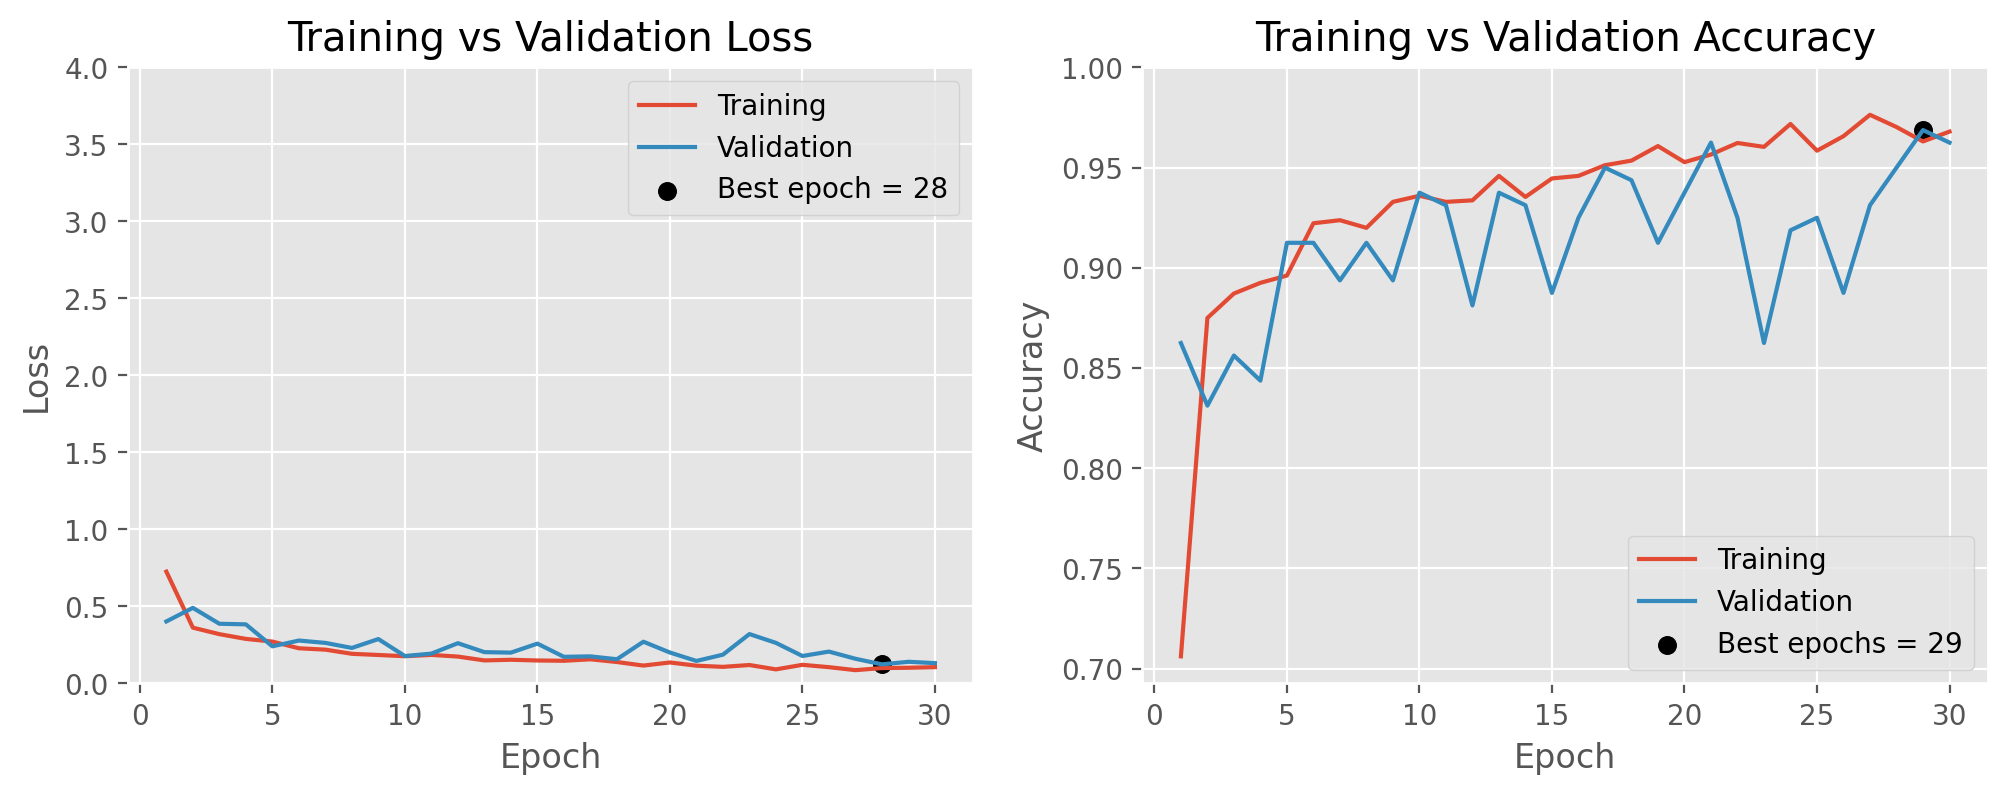

In [ ]:
curve_plot(resnet_history)

**Insights:**

Based on the above graphs, epoch 28 has the lowest loss
* loss: 0.0999
* val_loss: 0.1240
* Loss difference: 0.0241

epoch 29 has the best accuracy.
* accuracy: 0.9631
* val_accuracy: 0.9688
* Accuracy difference: 0.0057

In these epoches, it is worth noting that validation data performed better than training data.

However if we inspect the data further, the performance at epoch 21 is also good. In fact the validation accuracy value is only slightly lower than epoch 29.

* Epoch 21: loss: 0.1153 - accuracy: 0.9566 - val_loss: 0.1461 - val_accuracy: 0.9625
* Loss difference: 0.0308
* Accuracy difference: 0.0059

If we were to consider computational resources, training up to epoch 21 would be sufficient.



<b> Version 2 graphs </b>

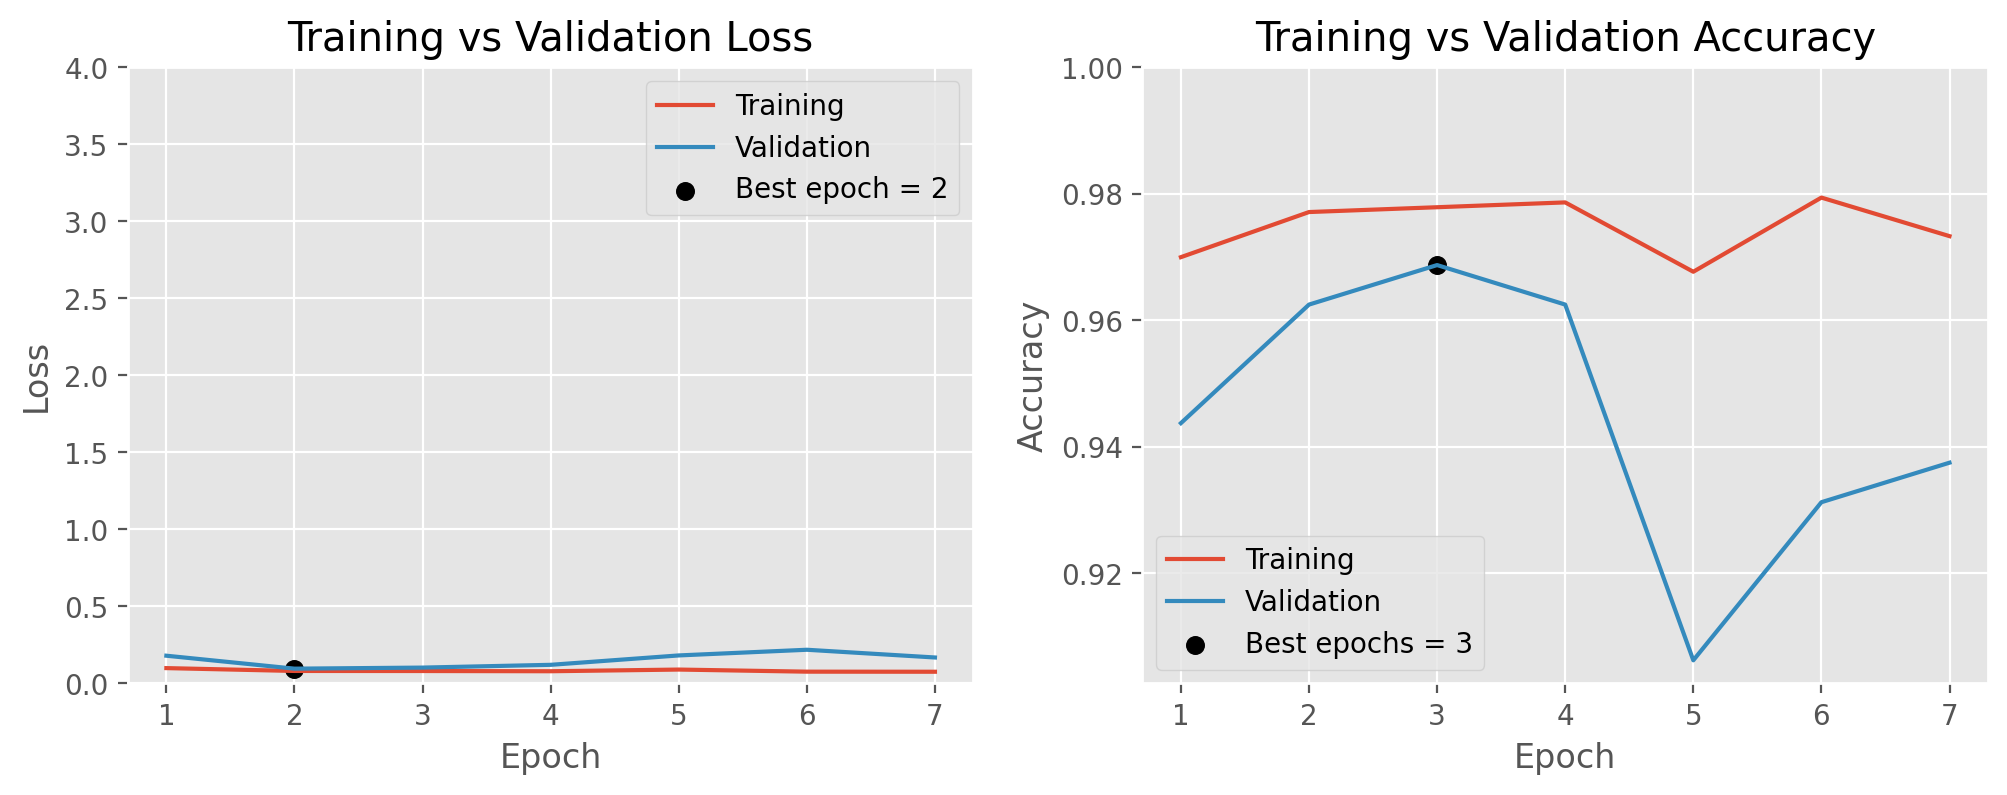

In [ ]:
curve_plot(resnet_history_2)

**Insights:**

Based on early stopping technique, the training stopped at epoch 7 out of 30.

Epoch 2 has the lowest loss
* loss: 0.0811
* val_loss: 0.0960

while epoch 3 has the best accuracy.
* accuracy: 0.9779
* val_accuracy: 0.9688

<b> Version 3 graphs </b>

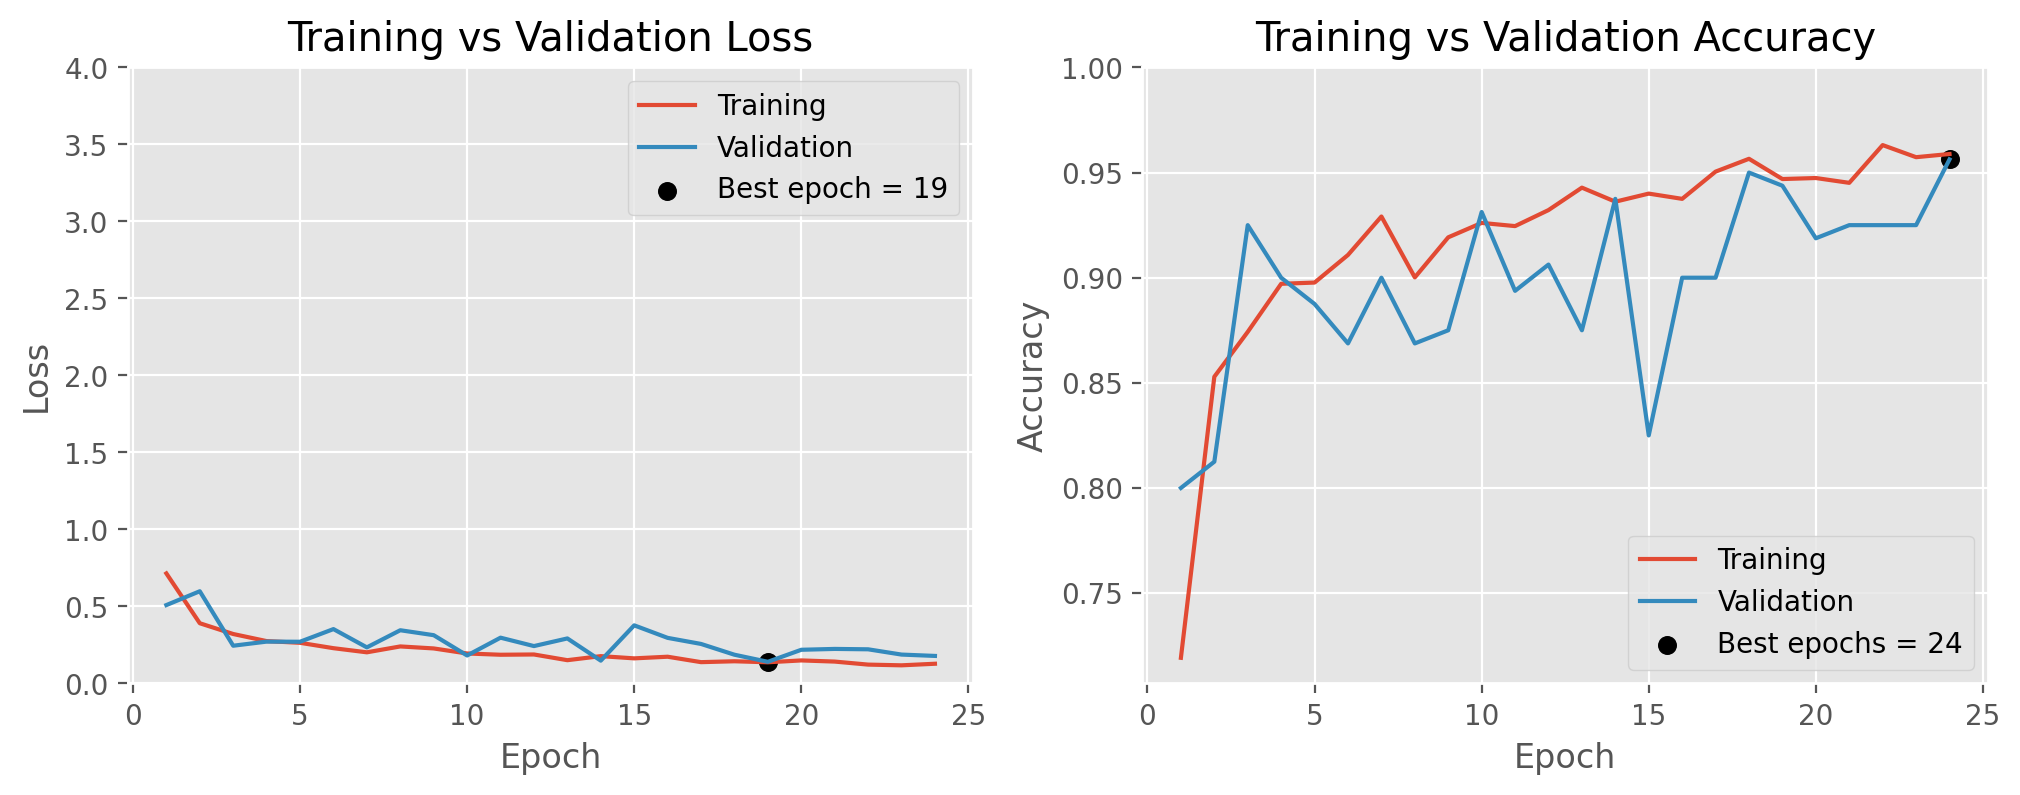

In [ ]:
curve_plot(resnet_history_3)

**Insights:**

Based on a RMSprop as an optimiser and the same early stopping hyperparameters used, the training stopped at epoch 24 out of 30.

Loss was least on epoch 19
  * loss: 0.1374
  * val_loss: 0.1406

while accuracy was considered the best at epoch 24
  * accuracy: 0.9588
  * val_accuracy: 0.9563


Nontheless, if we inspect the graph, there are also other earlier epochs which already gives sufficiently good scores such as:
* Epoch 10: loss: 0.1946 - accuracy: 0.9261 - val_loss: 0.1816 - val_accuracy: 0.9312

* Epoch 14: loss: 0.1773 - accuracy: 0.9362 - val_loss: 0.1481 - val_accuracy: 0.9375

<b> 1. With Adam optimizer </b>

In [ ]:
tf.keras.utils.set_random_seed(42)

# Evaluate the loss and accuracy
loss_resnet, accuracy_resnet = model_resnet.evaluate(test_gen)

# Print the accuracy
print("Accuracy: " + str(accuracy_resnet))
# Print the loss
print("Loss: " + str(loss_resnet))

41/41 [==============================] - 5s 113ms/step - loss: 0.1909 - accuracy: 0.9360
Accuracy: 0.9359756112098694
Loss: 0.19093161821365356


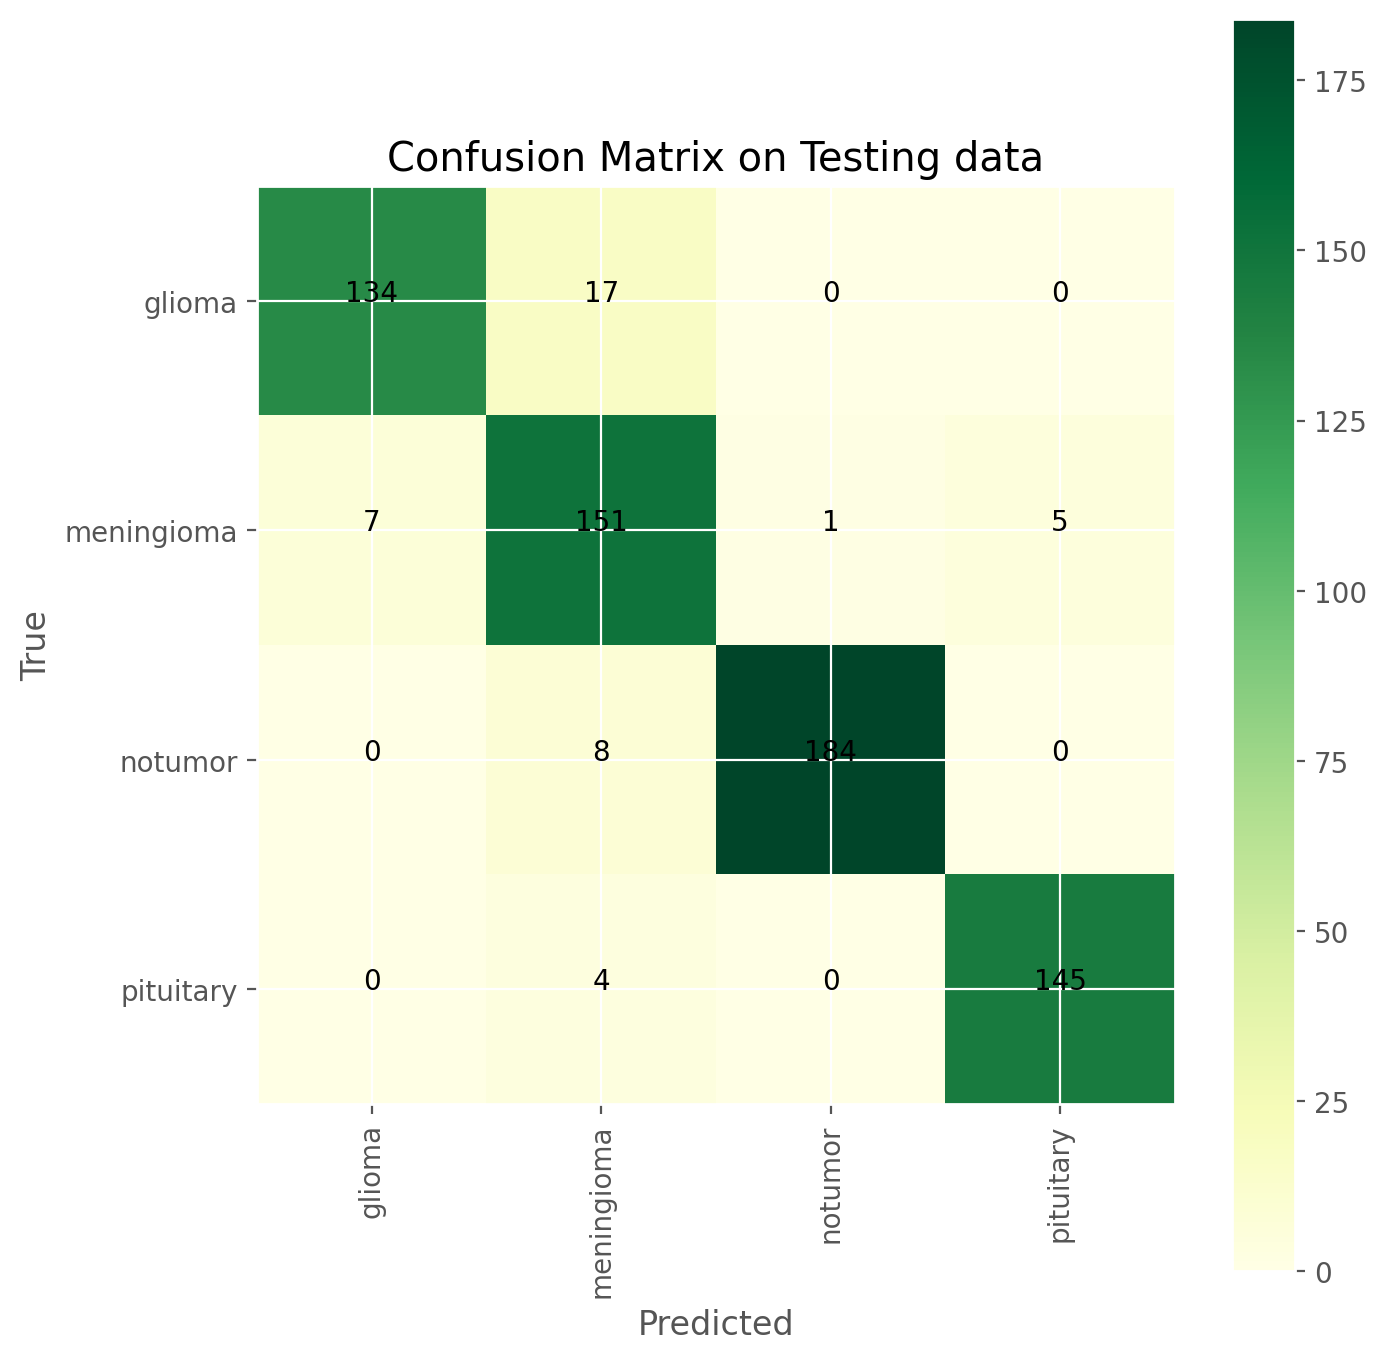

              precision    recall  f1-score   support

      glioma       0.95      0.89      0.92       151
  meningioma       0.84      0.92      0.88       164
     notumor       0.99      0.96      0.98       192
   pituitary       0.97      0.97      0.97       149

    accuracy                           0.94       656
   macro avg       0.94      0.93      0.94       656
weighted avg       0.94      0.94      0.94       656



In [ ]:
# invoke the function to plot cm
cm_report(model_resnet)

<b> 2. With RMSprop optimizer </b>

In [ ]:
tf.keras.utils.set_random_seed(42)

# Evaluate the loss and accuracy
loss_resnet_2, accuracy_resnet_2 = model_resnet_2.evaluate(test_gen)

# Print the accuracy
print("Accuracy: " + str(accuracy_resnet_2))
# Print the loss
print("Loss: " + str(loss_resnet_2))

41/41 [==============================] - 167s 4s/step - loss: 0.2263 - accuracy: 0.9223
Accuracy: 0.9222561120986938
Loss: 0.22631624341011047


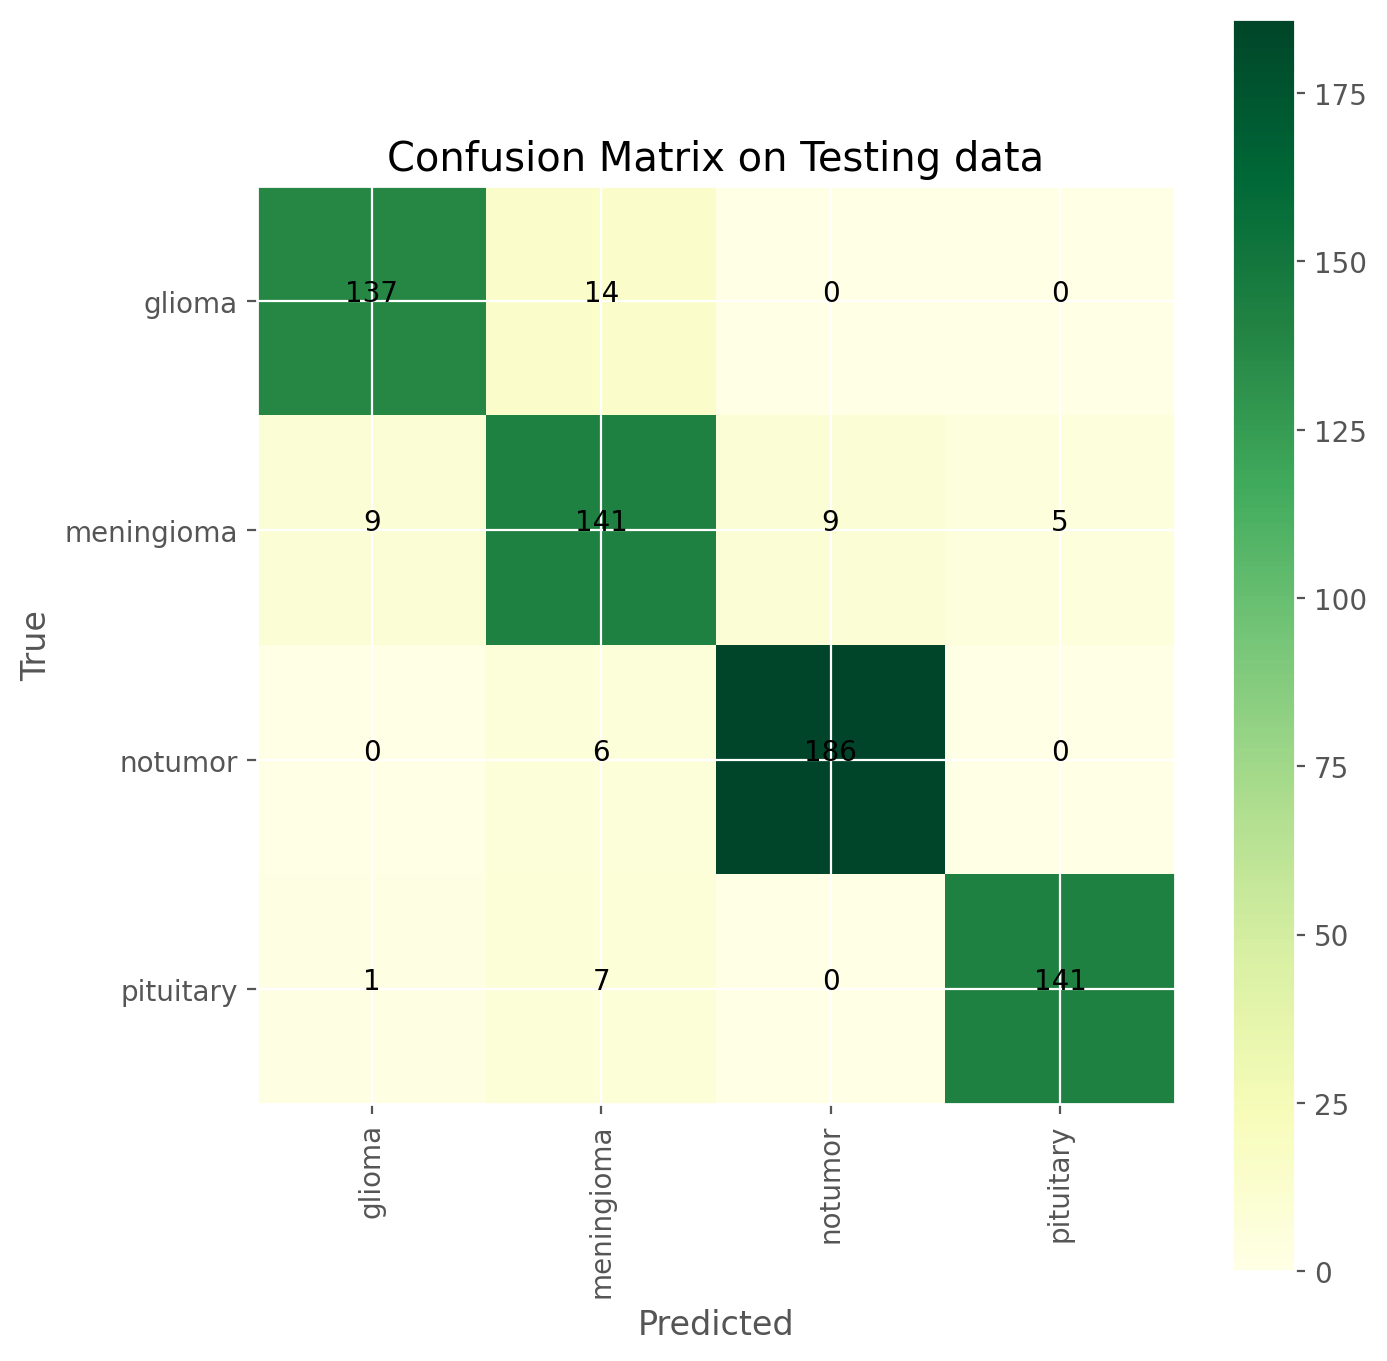

              precision    recall  f1-score   support

      glioma       0.93      0.91      0.92       151
  meningioma       0.84      0.86      0.85       164
     notumor       0.95      0.97      0.96       192
   pituitary       0.97      0.95      0.96       149

    accuracy                           0.92       656
   macro avg       0.92      0.92      0.92       656
weighted avg       0.92      0.92      0.92       656



In [ ]:
# invoke the function to plot cm
cm_report(model_resnet_2)

### Summary for ResNet50

The customised ResNet50 models have generally good accuracy scores on validation data for all 3 versions (at least 0.80). However the models with adam optimisers have a lower loss than when using RMSprop optimizer.

Adam optimiser:
  * Accuracy: 0.936
  * Loss: 0.190

RMSprop optimiser:
  * Accuracy: 0.922
  * Loss: 0.226

<br>

Considering the classification report scores, RMSprop was able to distinguish meningiomas and gliomas better than using Adam optimisers (the difference between precision and recall scores for these 2 lesions are closer). Ideally we would want a "balanced" performance across all 4 lesions in that model hence even though the overall accuracy and loss is not as good as Adam optimiser, in this case with ResNet50, the RMSprop optimiser worked better.

<br>

**Best model version for ResNet50:**
ResNet50 pretrained model using RMSprop optimiser

---

### (c) EfficientNetB2

For this pre-trained model, the input shape is different from the other two. This model will require a (260, 260, 3) input hence we will have to reprocess our images to the right shape before training. However, for uniformity sake, the preprocessing will be exactly the same as the other 2 pretrained models except for a change in input size.

In [ ]:
tf.keras.utils.set_random_seed(42)

# setting the image size to use imagedatagenerator on
image_size = (260, 260)

# set the batch size
# this number should be divisible by the number of images in our train, val and test set
# especially important for the testing data
batch_size = 16

# instantiate imagedatagenerator for each of the 3 data (train, val and test)
tr_gen_effnet = ImageDataGenerator()
val_gen_effnet = ImageDataGenerator()
ts_gen_effnet = ImageDataGenerator()

train_gen_effnet = tr_gen_effnet.flow_from_dataframe(train_df_balanced, x_col = "filepaths", y_col = "labels", target_size = image_size, seed = 42,
                                          class_mode = "categorical", color_mode = "rgb", shuffle = True, batch_size = batch_size)

valid_gen_effnet = val_gen_effnet.flow_from_dataframe(val_df, x_col = "filepaths", y_col = "labels", target_size = image_size, seed = 42,
                                             class_mode = "categorical", color_mode = "rgb", shuffle = True, batch_size = batch_size)

test_gen_effnet = ts_gen_effnet.flow_from_dataframe(testing_df , x_col = "filepaths" , y_col = "labels", target_size = image_size, seed = 42,
                                        class_mode = "categorical", color_mode= "rgb" , shuffle = False , batch_size = batch_size) # note: shuffle = False for testing data

Found 5284 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


<b> Rechecking the images after resizing </b>


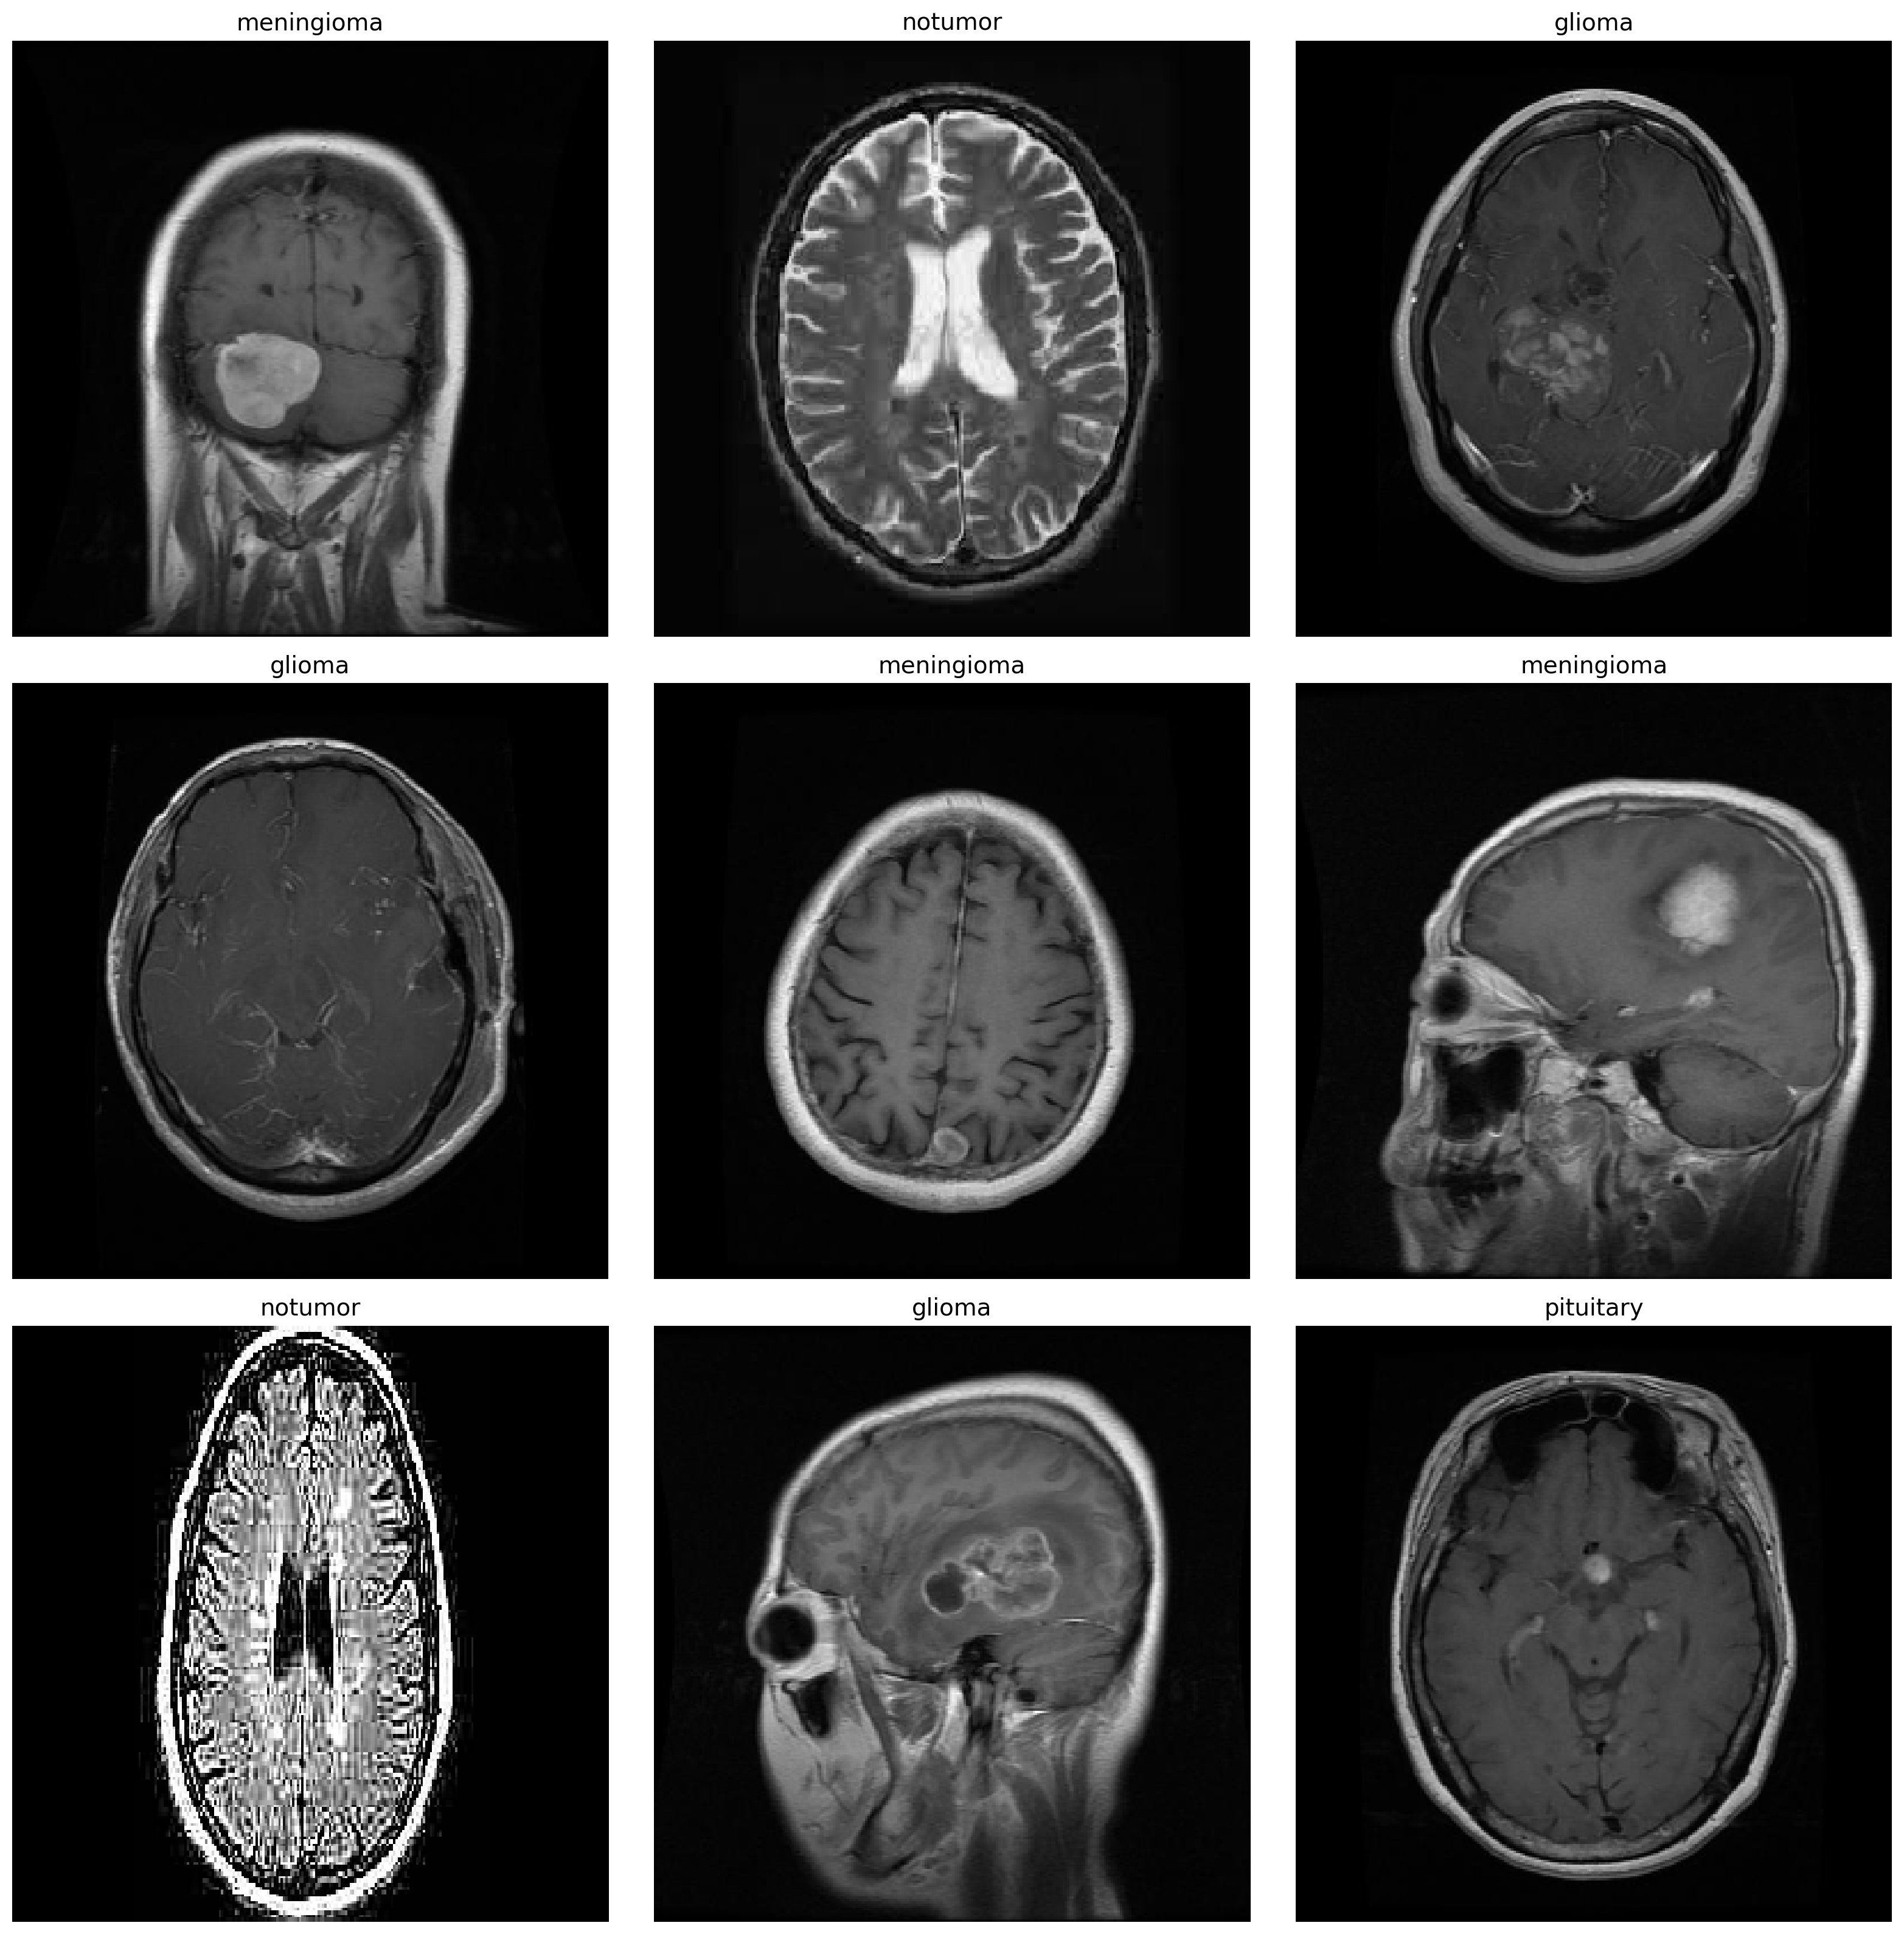

In [ ]:
# invoke the function on train_gen_effnet
norm_image(train_gen_effnet)

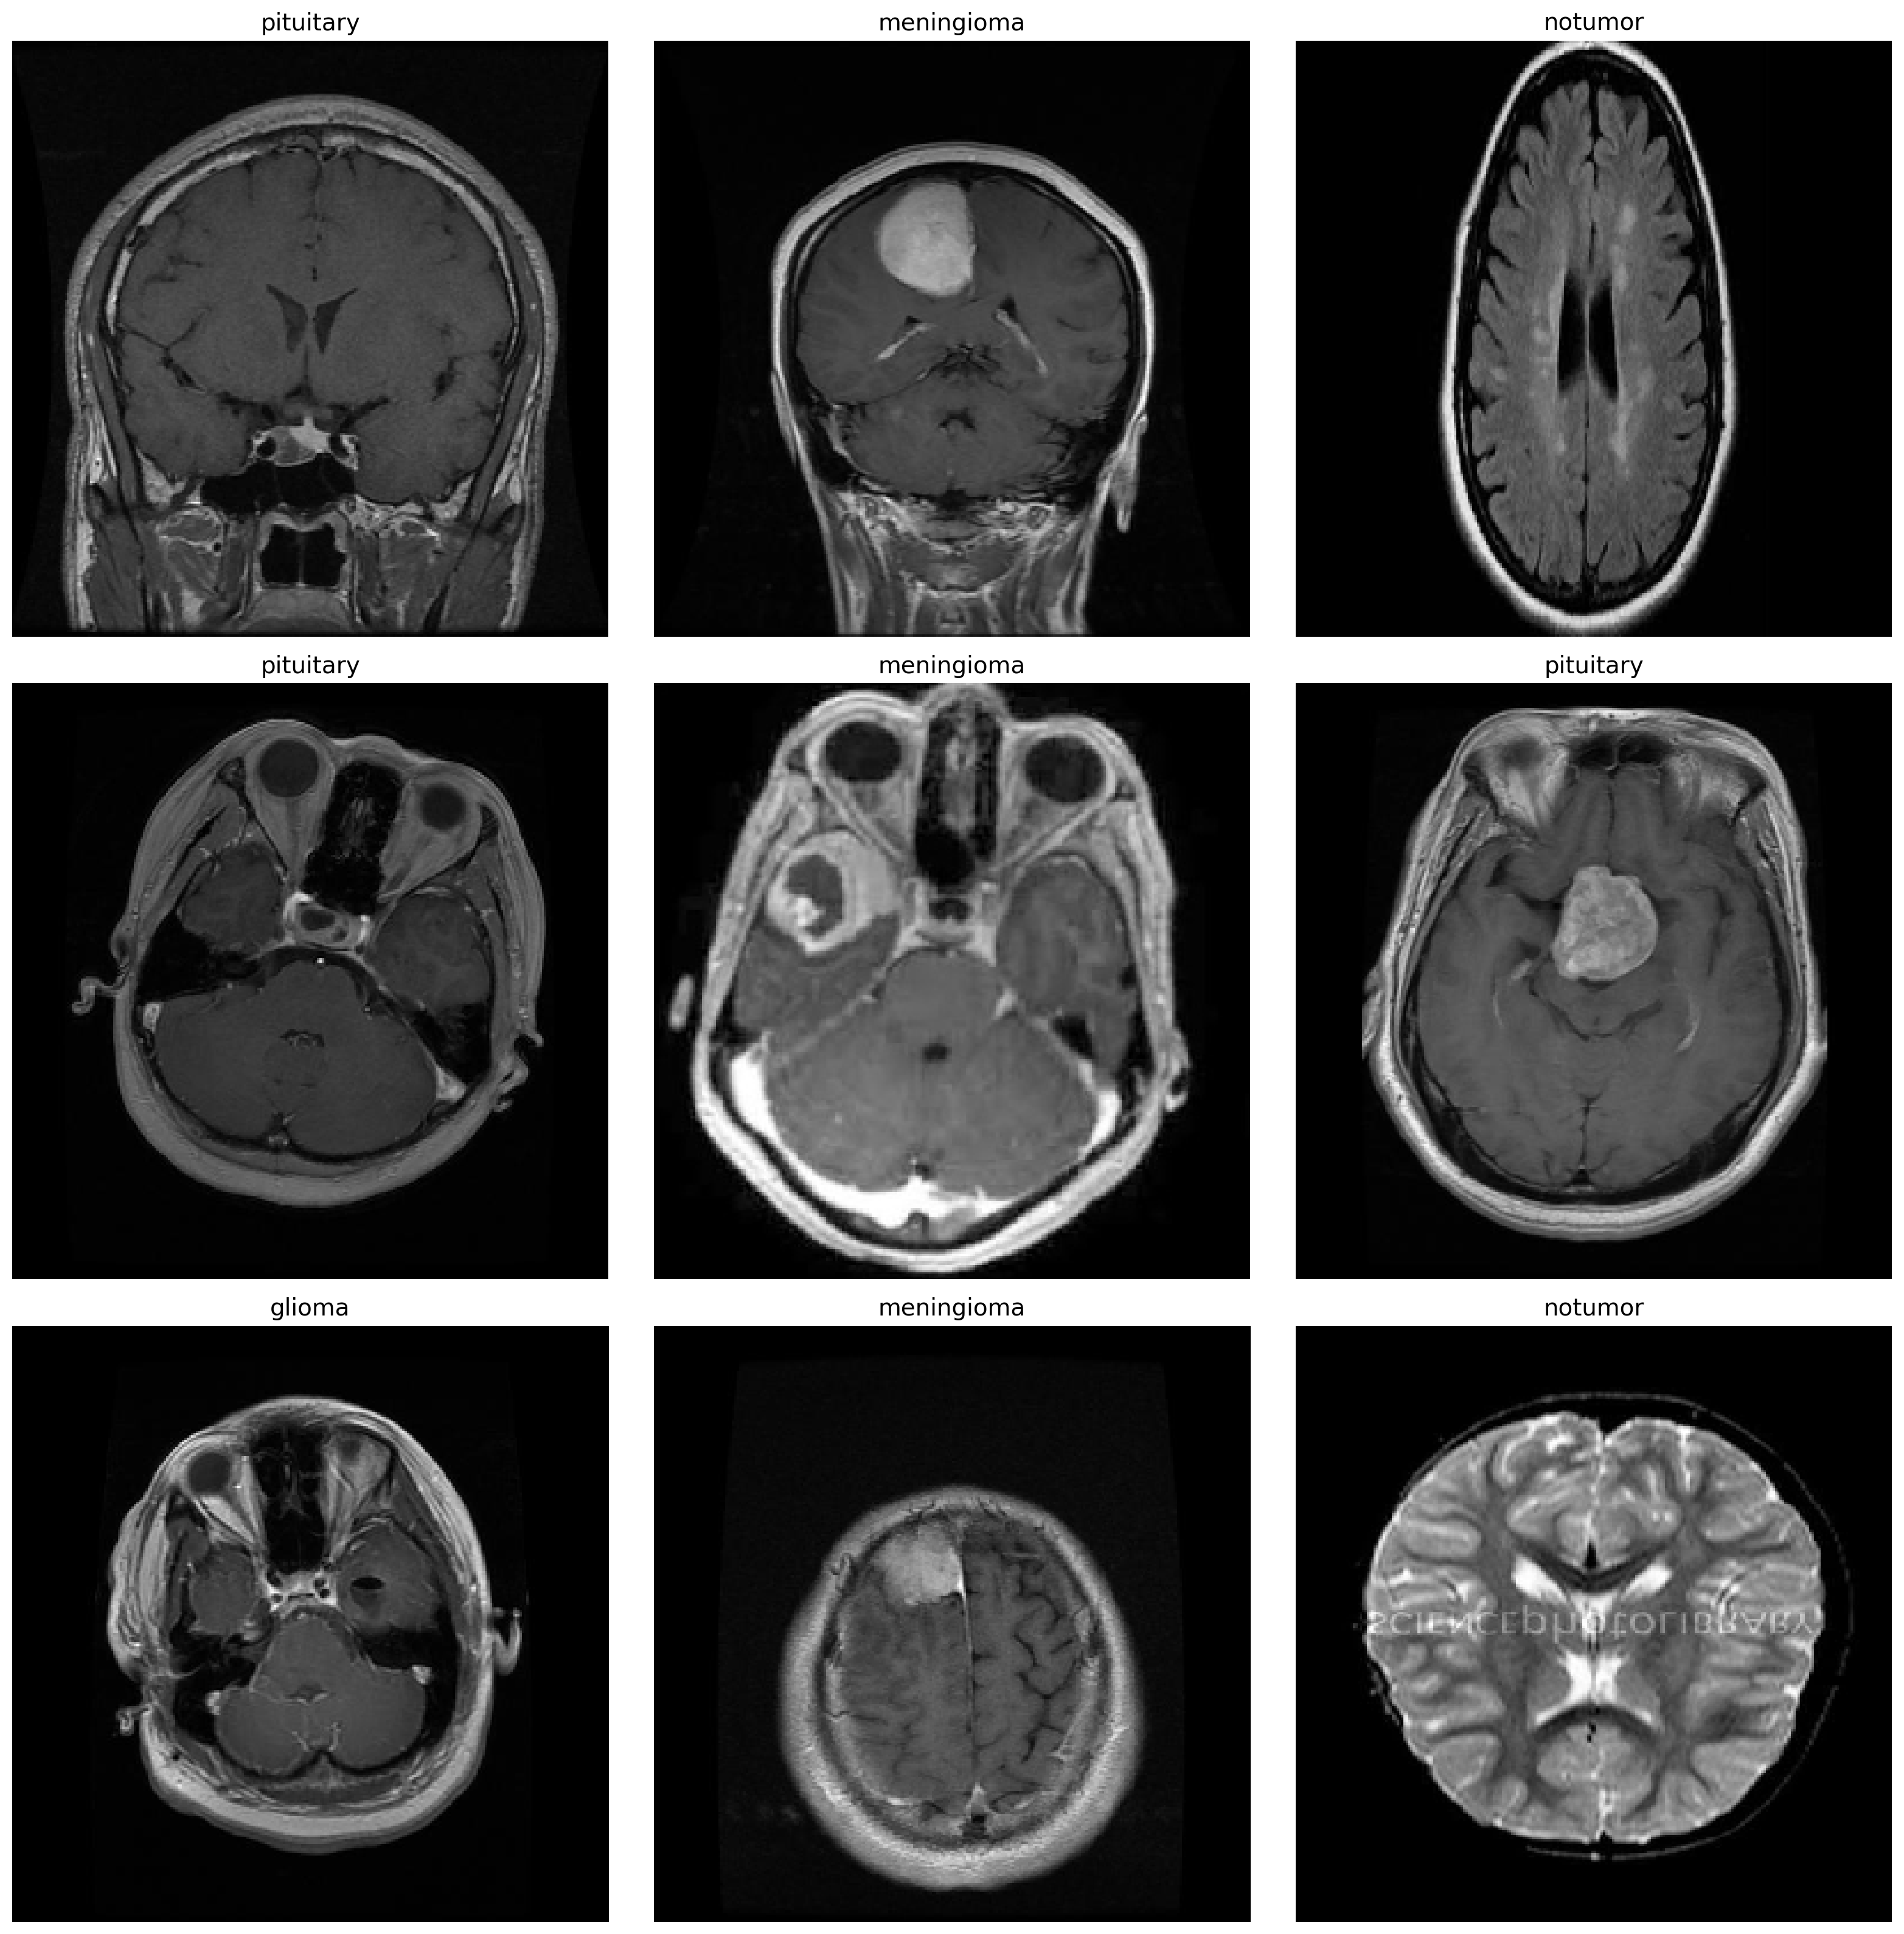

In [ ]:
# invoke the function on valid_gen_effnet
norm_image(valid_gen_effnet)

<b> Modeling </b>

In [ ]:
# instantiate efficientnetb2 model (pre-trained)
effnet = EfficientNetB2()

# see model summary
print(effnet.summary())

37432240/37432240 [==============================] - 0s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 260, 260, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 260, 260, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 260, 260, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescal

**Insights:**

Based on the summary table, the input image have to have an input of (260, 260, 3) - which we have already reprocessed our images in the previous section. We will keep the original architecture up to block7b (have to use `include_top = False` and freeze the layers).

<b> Version 1: </b>

We will customise the last layer for our brain dataset to 4 outputs intead of 1000. For EfficientNetB2, it is similar to ResNet50 where it uses `global average pooling` instead of `flatten` for converting the images to a 1D array.

When we fit the model, we will also use similar `batch size`, `steps_per_epoch` and `validation_steps` so that it is comparable to the other 2 pre-trained models for evaluation later on.

In [ ]:
# instantiate the model that we want to use
# activate include_top = False  - we do not want the last layer - we will customise it but we will still use weights from imagenet

image_shape = (260, 260, 3)
base_effnet = EfficientNetB2(include_top = False, weights = "imagenet", input_shape = image_shape)

# freeze all the other layers so we don't accidentally change the pre-trained model parameters
for layer in base_effnet.layers:
  layer.trainable = False

In [ ]:
# # create an empty nn model
model_effnet = Sequential()

# add the effnet original architecture in without the top layer
model_effnet.add(base_effnet)

# add in our dense layers to get a fully connected layer
# but we need to switch the last layer to 4 outputs
# we also addd in the Dropout layer to mimic the original architecture
model_effnet.add(GlobalAveragePooling2D())
model_effnet.add(Dropout(0.2)) # we will choose a small value to start with
model_effnet.add(Dense(units = 4, activation = "softmax"))

# compile the model with the loss, optimiser and metrics
# set the optimiser at a very low learning rate to not disrupt the weights of the original pretrained model
opt = Adam(learning_rate = 0.001)

model_effnet.compile(loss = "categorical_crossentropy",
                  optimizer = opt,
                  metrics = ["accuracy"])

# check the new summary of our model
model_effnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 9, 9, 1408)        7768569   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 4)                 5636      
                                                                 
Total params: 7774205 (29.66 MB)
Trainable params: 5636 (22.02 KB)
Non-trainable params: 7768569 (29.63 MB)
_________________________________________________________________


<b> Training the model </b>

In [ ]:
# fit in the training data
%%time
tf.keras.utils.set_random_seed(42)

effnet_history = model_effnet.fit(x = train_gen_effnet, epochs = 30,
                                         validation_data = valid_gen_effnet, batch_size = 64,
                                         steps_per_epoch = 82, validation_steps = 10, verbose = 1)

Epoch 1/30
82/82 [==============================] - 12s 138ms/step - loss: 0.3420 - accuracy: 0.8754 - val_loss: 0.3872 - val_accuracy: 0.8500
Epoch 2/30
82/82 [==============================] - 10s 119ms/step - loss: 0.3226 - accuracy: 0.8819 - val_loss: 0.3461 - val_accuracy: 0.8625
Epoch 3/30
82/82 [==============================] - 10s 119ms/step - loss: 0.2707 - accuracy: 0.9101 - val_loss: 0.2694 - val_accuracy: 0.9125
Epoch 4/30
82/82 [==============================] - 10s 123ms/step - loss: 0.2949 - accuracy: 0.8933 - val_loss: 0.2562 - val_accuracy: 0.9250
Epoch 5/30
82/82 [==============================] - 8s 103ms/step - loss: 0.2660 - accuracy: 0.9015 - val_loss: 0.3706 - val_accuracy: 0.8562
Epoch 6/30
82/82 [==============================] - 10s 121ms/step - loss: 0.2621 - accuracy: 0.9032 - val_loss: 0.2904 - val_accuracy: 0.8813
Epoch 7/30
82/82 [==============================] - 10s 118ms/step - loss: 0.2600 - accuracy: 0.9131 - val_loss: 0.2611 - val_accuracy: 0.9187


<b> Version 2: Adding in a regularization technique </b>

We will add in early stopping for Version 2. For uniformity sake, we are using the same early stopping hyperparameters as the one we used in VGG16 and ResNet50 so that we can compare results across all 3 pre-trained models.

In [ ]:
# fit in the training data with early_stopping
%%time
tf.keras.utils.set_random_seed(42)

effnet_history_2 = model_effnet.fit(x = train_gen_effnet, epochs = 30,
                                    validation_data = valid_gen_effnet, batch_size = 64,
                                    steps_per_epoch = 82, validation_steps = 10,
                                    callbacks = [early_stop], verbose = 1)

Epoch 1/30
82/82 [==============================] - 10s 114ms/step - loss: 0.2040 - accuracy: 0.9246 - val_loss: 0.1852 - val_accuracy: 0.9563
Epoch 2/30
82/82 [==============================] - 9s 113ms/step - loss: 0.1913 - accuracy: 0.9421 - val_loss: 0.1828 - val_accuracy: 0.9563
Epoch 3/30
82/82 [==============================] - 9s 115ms/step - loss: 0.2110 - accuracy: 0.9253 - val_loss: 0.1822 - val_accuracy: 0.9438
Epoch 4/30
82/82 [==============================] - 10s 123ms/step - loss: 0.1694 - accuracy: 0.9436 - val_loss: 0.2375 - val_accuracy: 0.9062
Epoch 5/30
82/82 [==============================] - 8s 101ms/step - loss: 0.2253 - accuracy: 0.9092 - val_loss: 0.2294 - val_accuracy: 0.9438
Epoch 6/30
82/82 [==============================] - 9s 106ms/step - loss: 0.1769 - accuracy: 0.9383 - val_loss: 0.1993 - val_accuracy: 0.9125
Epoch 7/30
82/82 [==============================] - 9s 115ms/step - loss: 0.1913 - accuracy: 0.9398 - val_loss: 0.1564 - val_accuracy: 0.9375
Epoc

<b> Version 3: Changing the optimizer </b>

Similar to VGG16 and Resnet's Version 3, we will use RMSprop instead of Adam optimiser in this version and with early stopping.

In [ ]:
# create an empty nn model
model_effnet_2 = Sequential()

# add the effnet original architecture in without the top layer
model_effnet_2.add(base_effnet)

# add in our dense layers to get a fully connected layer
# but we need to switch the last layer to 4 outputs
# we also addd in the Dropout layer to mimic the original architecture
model_effnet_2.add(GlobalAveragePooling2D())
model_effnet_2.add(Dropout(0.2)) # we will choose a small value to start with
model_effnet_2.add(Dense(units = 4, activation = "softmax"))

# compile the model with the loss, optimiser and metrics
# set the optimiser at a very low learning rate to not disrupt the weights of the original pretrained model
opt_2 = RMSprop(learning_rate = 0.001)

model_effnet_2.compile(loss = "categorical_crossentropy",
                  optimizer = opt_2,
                  metrics = ["accuracy"])

# check the new summary of our model
model_effnet_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 9, 9, 1408)        7768569   
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1408)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5636      
                                                                 
Total params: 7774205 (29.66 MB)
Trainable params: 5636 (22.02 KB)
Non-trainable params: 7768569 (29.63 MB)
_________________________________________________________________


<b> Training the model </b>


In [ ]:
# fit in the training data with early_stopping and RMSprop optimizer
%%time
tf.keras.utils.set_random_seed(42)

effnet_history_3 = model_effnet_2.fit(x = train_gen_effnet, epochs = 30,
                                      validation_data = valid_gen_effnet, batch_size = 64,
                                      steps_per_epoch = 82, validation_steps = 10,
                                      callbacks = [early_stop], verbose = 1)

Epoch 1/30
82/82 [==============================] - 46s 444ms/step - loss: 0.7893 - accuracy: 0.7231 - val_loss: 0.5996 - val_accuracy: 0.7812
Epoch 2/30
82/82 [==============================] - 64s 783ms/step - loss: 0.5011 - accuracy: 0.8239 - val_loss: 0.6524 - val_accuracy: 0.7437
Epoch 3/30
82/82 [==============================] - 50s 616ms/step - loss: 0.4276 - accuracy: 0.8430 - val_loss: 0.4474 - val_accuracy: 0.8313
Epoch 4/30
82/82 [==============================] - 39s 485ms/step - loss: 0.3788 - accuracy: 0.8697 - val_loss: 0.3807 - val_accuracy: 0.8562
Epoch 5/30
82/82 [==============================] - 29s 357ms/step - loss: 0.3536 - accuracy: 0.8692 - val_loss: 0.4444 - val_accuracy: 0.8313
Epoch 6/30
82/82 [==============================] - 26s 313ms/step - loss: 0.3137 - accuracy: 0.8925 - val_loss: 0.4685 - val_accuracy: 0.8438
Epoch 7/30
82/82 [==============================] - 23s 280ms/step - loss: 0.3201 - accuracy: 0.8902 - val_loss: 0.3160 - val_accuracy: 0.8562

<b> Plotting the accuracy and loss graphs </b>

We will use the same function `curve_plot(history)` to do this.

<b> Version 1 graphs </b>

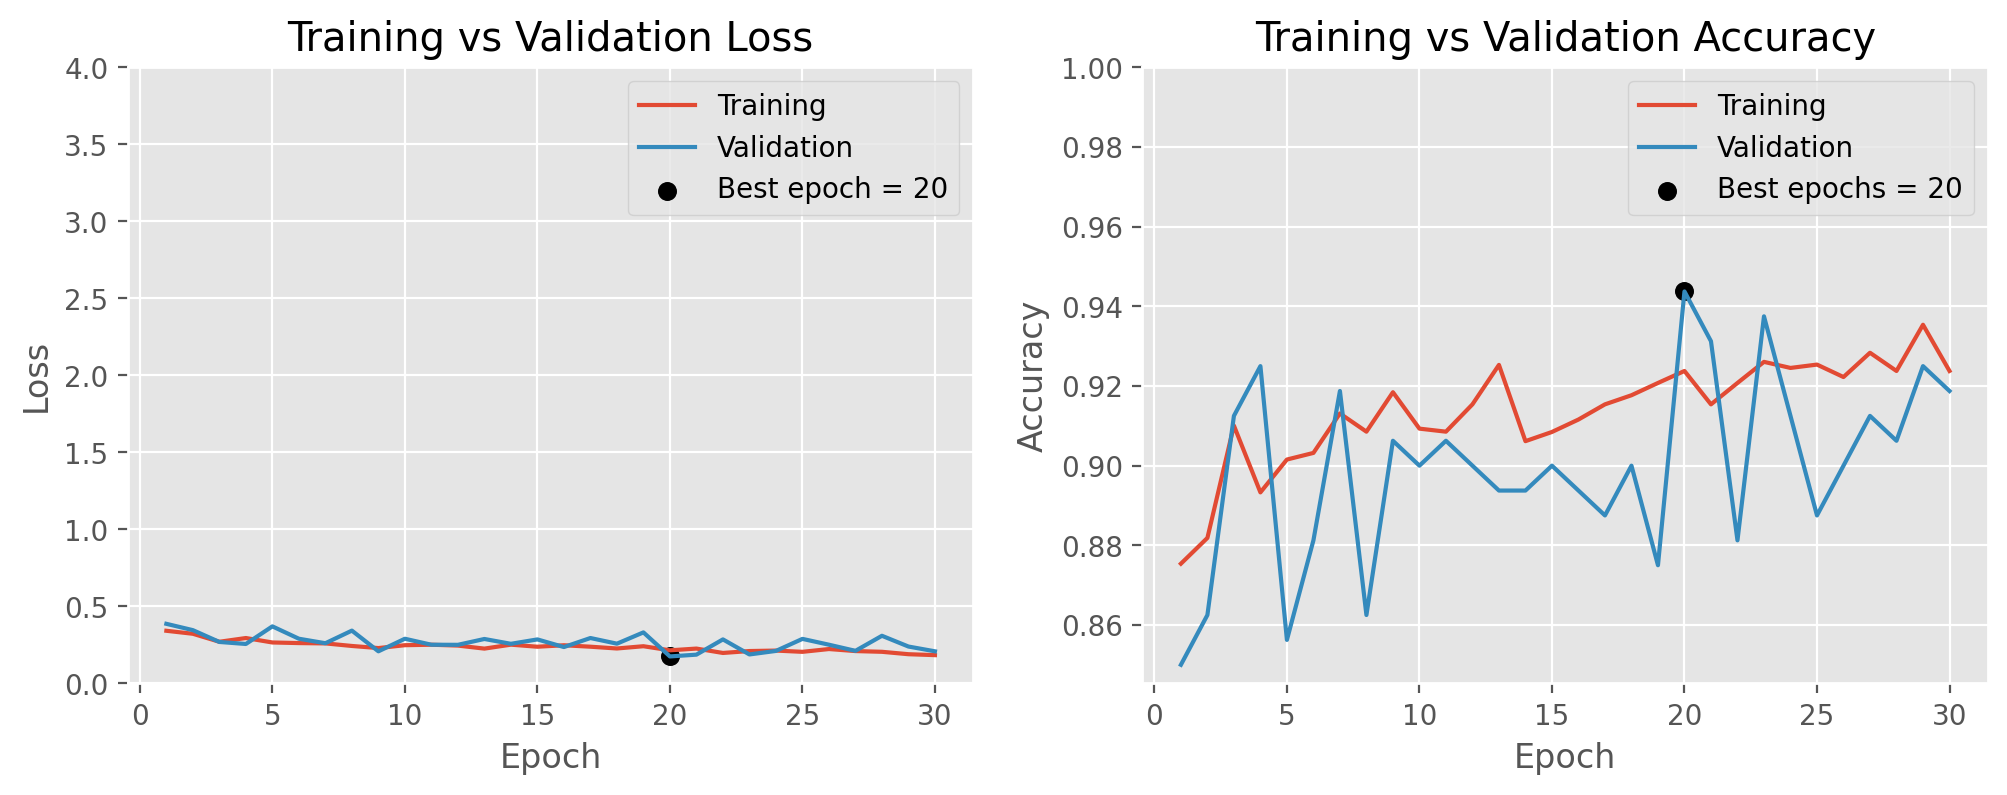

In [ ]:
curve_plot(effnet_history)

**Insights:**

Based on the above graphs, epoch 20 has the lowest loss and highest accuracy. In this case, the validation data outperformed the training data.

  * loss: 0.2151
  * val_loss: 0.1754
    * Loss difference: 0.0397

  * accuracy: 0.9238
  * val_accuracy: 0.9438
    * Accuracy difference: 0.02

<br>

If we inspect the graph further, while epoch 20 has the best validation accuracy in terms of absolute numbers, if we consider the loss and accuracy difference, it might not be the best. In fact, epoch 7 might be the best performing one:

   * Epoch 7: loss: 0.2600 - accuracy: 0.9131 - val_loss: 0.2611 - val_accuracy: 0.9187
   * Loss difference: 0.0011
   * Accuracy difference: 0.0056

   In this case, we might not need to train our cnn model for that many epochs before we can get a sufficiently good score.

<b> Version 2 graphs </b>

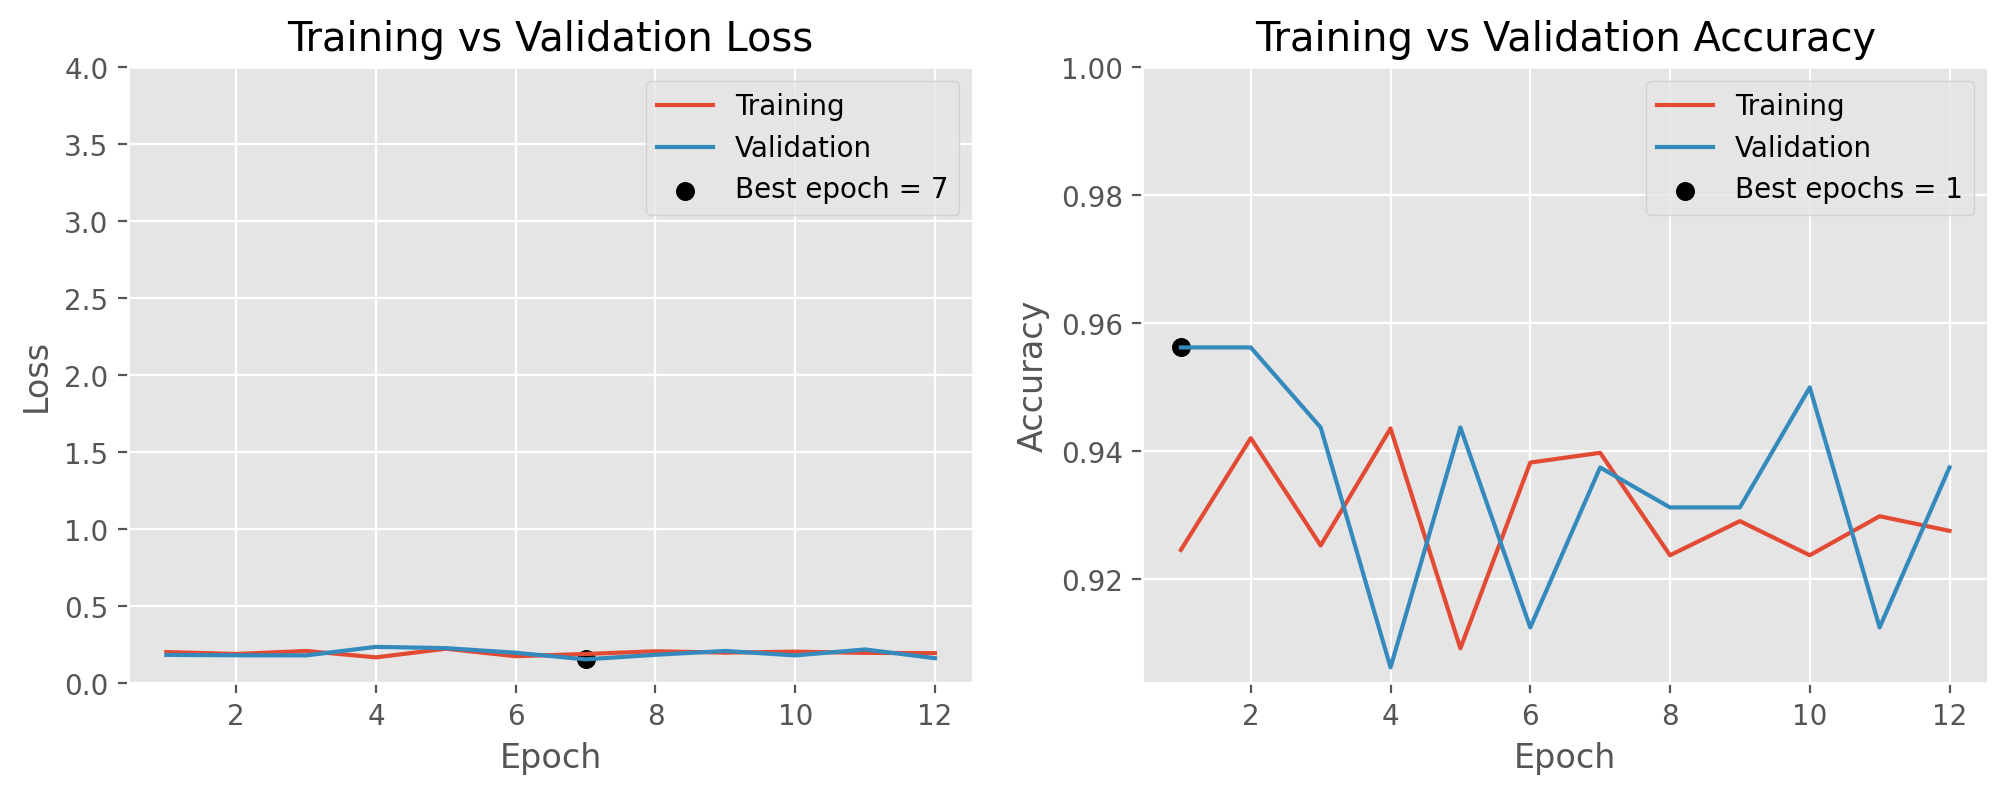

In [ ]:
curve_plot(effnet_history_2)

**Insights:**

Based on early stopping technique, the training stopped at epoch 12 out of 30.

Epoch 7 has the lowest loss
  * loss: 0.1913
  * val_loss: 0.1564

while epoch 1 has the best accuracy.
  * accuracy: 0.9246
  * val_accuracy: 0.9563

Nonetheless, the accuracy difference at epoch 7 is the smallest between the training and validation data hence overall epoch 7 will likely be the best for this model as illustrated:

  * Epoch 7: loss: 0.1913 - accuracy: 0.9398 - val_loss: 0.1564 - val_accuracy: 0.9375

<br>

*Bonus Insights (Whee!)*:

Interestingly, this coincide with our Version 1 model where based on the same training and valiadtion data, by epoch 7 our model seems to have achieved sufficiently good results. If we compare both epochs, then Version 2 would be a better model with lower losses scores overall and higher accuracy.

<b> Version 3 graphs </b>

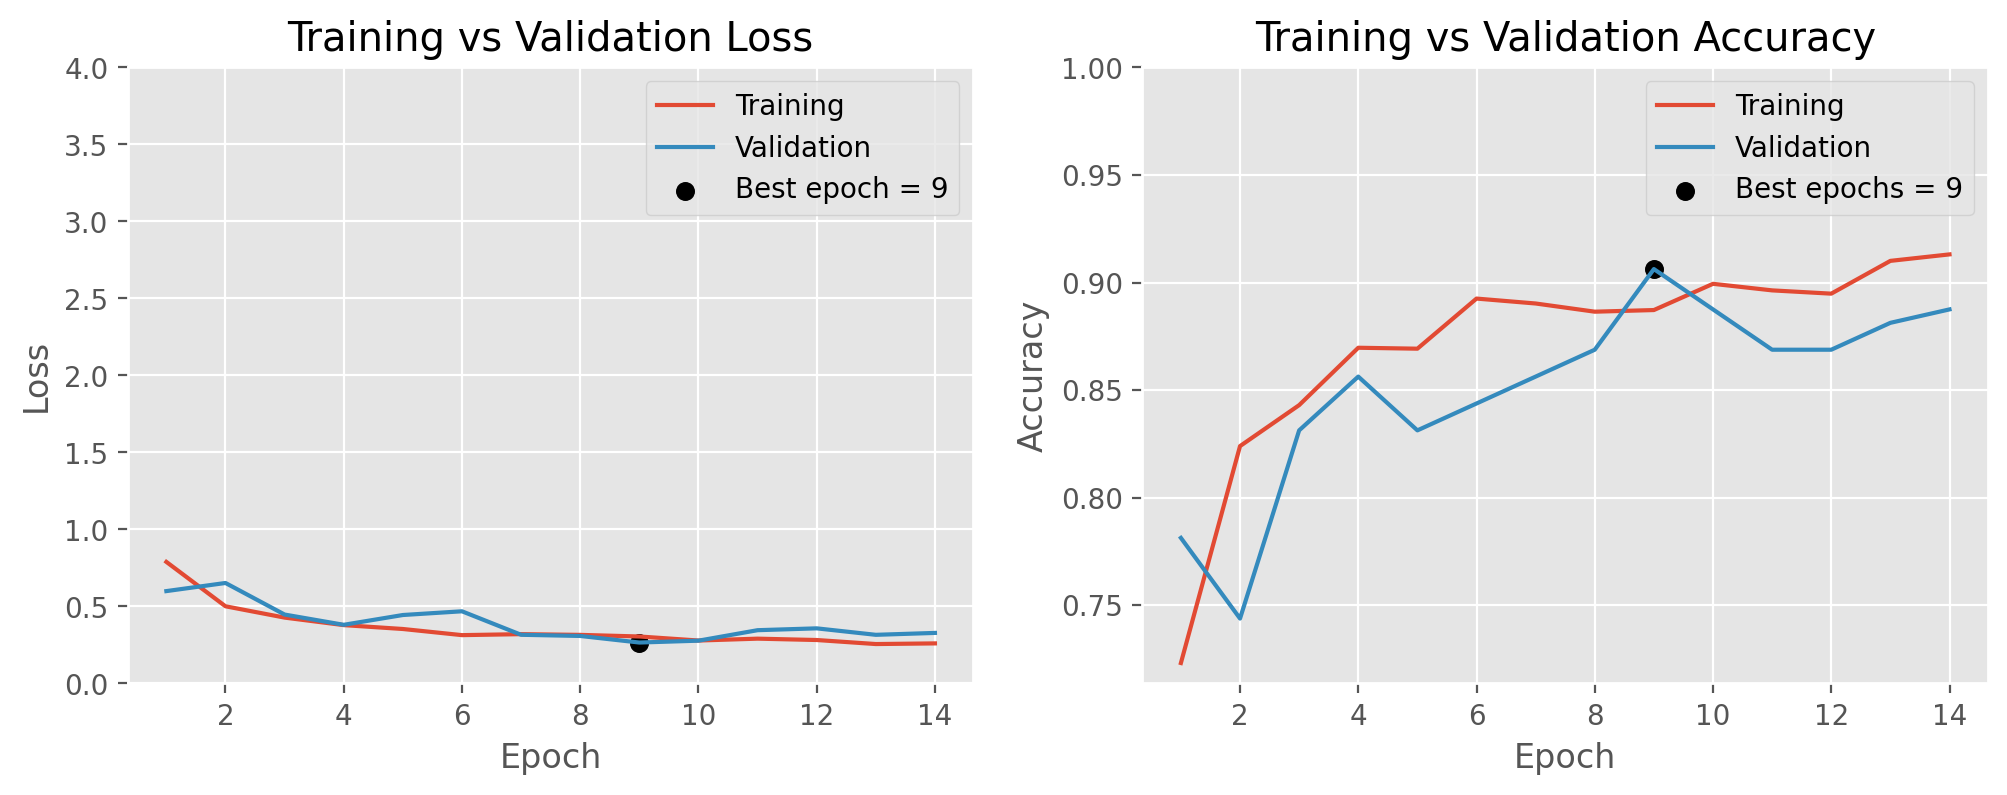

In [ ]:
curve_plot(effnet_history_3)

**Insights:**

Based on early stopping technique and using RMSprop as the optimizer, training stopped at epoch 14 out of 30.

Epoch 9 performed the best, with validation data performance better than training data.
  * loss: 0.3049
  * val_loss: 0.2656
  * accuracy: 0.8872
  * val_accuracy: 0.9062

<b> 1. With Adam optimizer </b>

In [ ]:
tf.keras.utils.set_random_seed(42)

# Evaluate the loss and accuracy
loss_effnet, accuracy_effnet = model_effnet.evaluate(test_gen_effnet)

# Print the accuracy
print("Accuracy: " + str(accuracy_effnet))
# Print the loss
print("Loss: " + str(loss_effnet))

41/41 [==============================] - 4s 88ms/step - loss: 0.2211 - accuracy: 0.9146
Accuracy: 0.9146341681480408
Loss: 0.2210645228624344


In [ ]:
# creating a function that will generate the confusion matrix on the testing dataset and classification report but for effnet only

def cm_report_effnet(model):
  # predicting an image
  preds = model.predict_generator(test_gen_effnet)
  y_preds_effnet = np.argmax(preds , axis = 1)

  # .class_indices defines dicionary for our test_gen
  test_labels_effnet = test_gen_effnet.class_indices

  # get the keys of test_labels into a list
  list_test_labels_effnet = list(test_labels_effnet.keys())

  # generate the confusion matrix
  cm = confusion_matrix(test_gen_effnet.classes, y_preds_effnet)


  # plot the confusion matrix
  # set the size of the plot
  plt.figure(figsize = (7, 7))

  # displays data as images
  plt.imshow(cm, interpolation = "nearest", cmap = "YlGn")
  plt.colorbar()

  # set the axes labels and title of plot
  plt.title("Confusion Matrix on Testing data")
  x_axis_labels = np.arange(len(list_test_labels_effnet))
  plt.xticks(x_axis_labels, list_test_labels_effnet, rotation = 90)
  plt.yticks(x_axis_labels, list_test_labels_effnet)

  # annotations for the cm
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "black")

  plt.tight_layout()
  plt.ylabel("True")
  plt.xlabel("Predicted")

  plt.show()

  # classification report
  print(classification_report(test_gen_effnet.classes, y_preds_effnet, target_names = list_test_labels_effnet))
  return

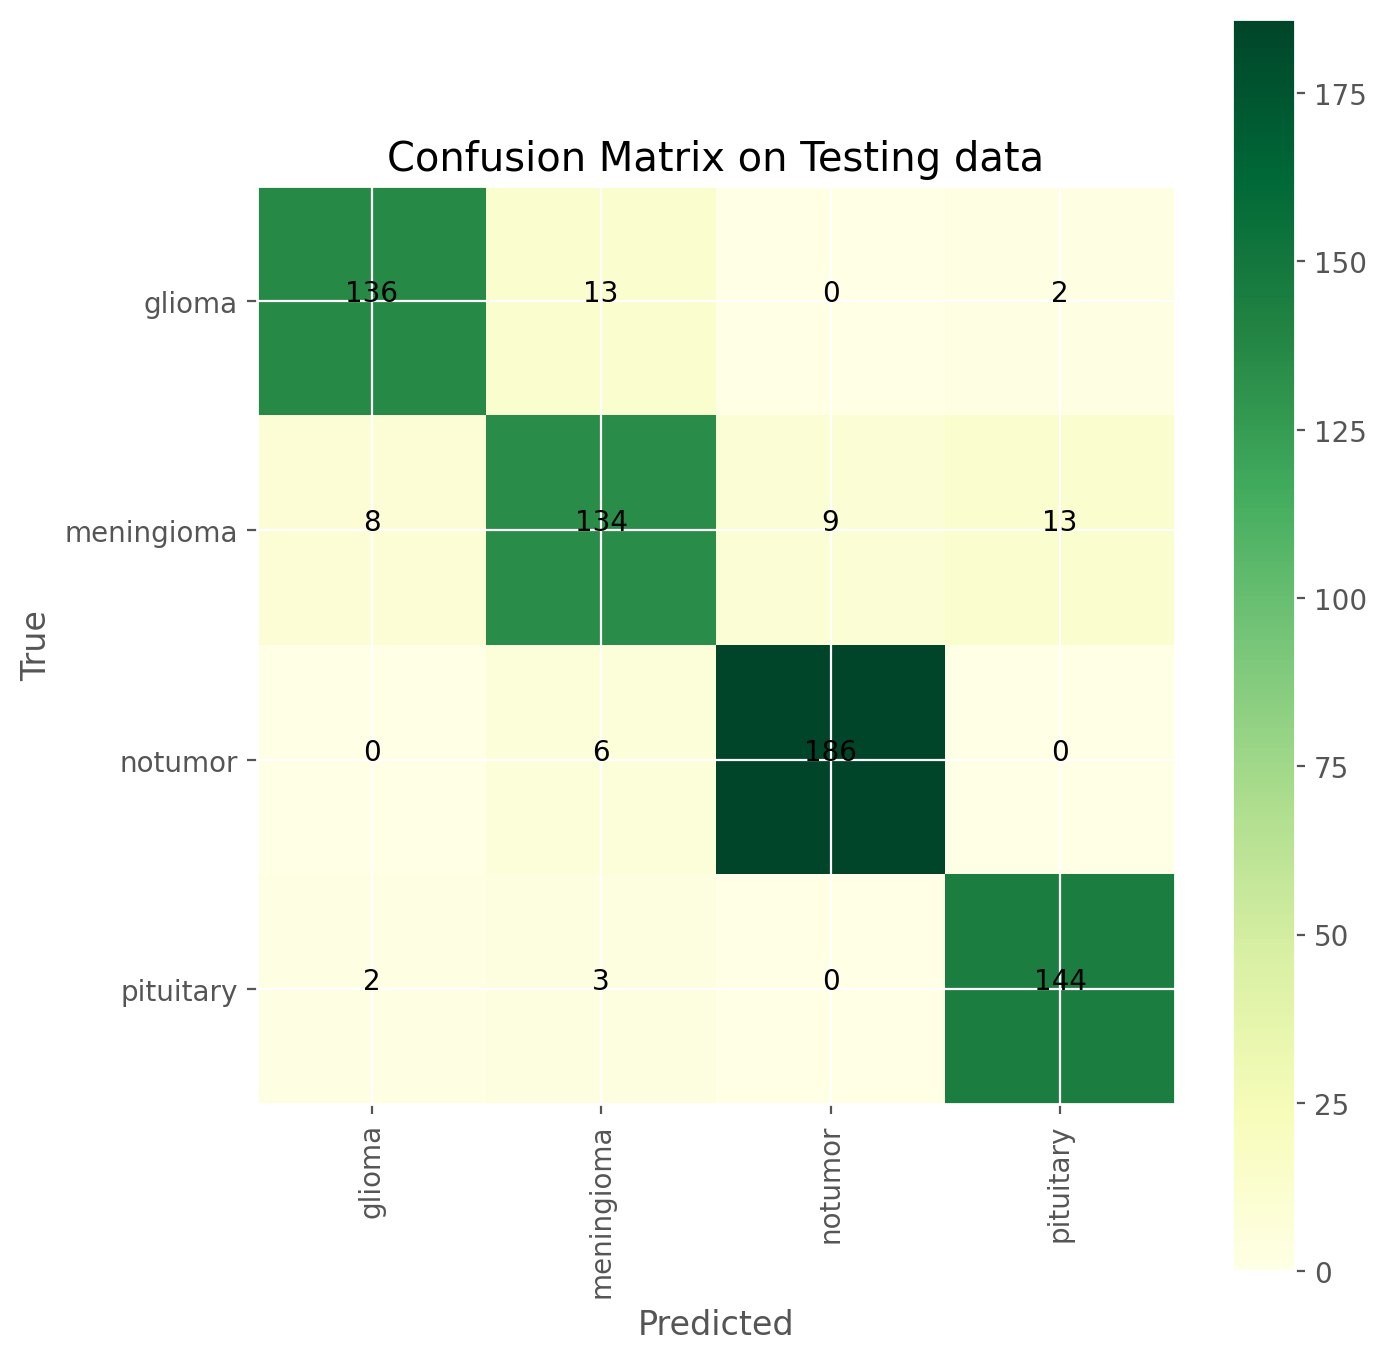

              precision    recall  f1-score   support

      glioma       0.93      0.90      0.92       151
  meningioma       0.86      0.82      0.84       164
     notumor       0.95      0.97      0.96       192
   pituitary       0.91      0.97      0.94       149

    accuracy                           0.91       656
   macro avg       0.91      0.91      0.91       656
weighted avg       0.91      0.91      0.91       656



In [ ]:
# invoke the function to plot cm
cm_report_effnet(model_effnet)

<b> 2. With RMSprop optimizer </b>

In [ ]:
tf.keras.utils.set_random_seed(42)

# Evaluate the loss and accuracy
loss_effnet_2, accuracy_effnet_2 = model_effnet_2.evaluate(test_gen_effnet)

# Print the accuracy
print("Accuracy: " + str(accuracy_effnet_2))
# Print the loss
print("Loss: " + str(loss_effnet_2))

41/41 [==============================] - 168s 4s/step - loss: 0.3326 - accuracy: 0.8613
Accuracy: 0.8612805008888245
Loss: 0.3326221704483032


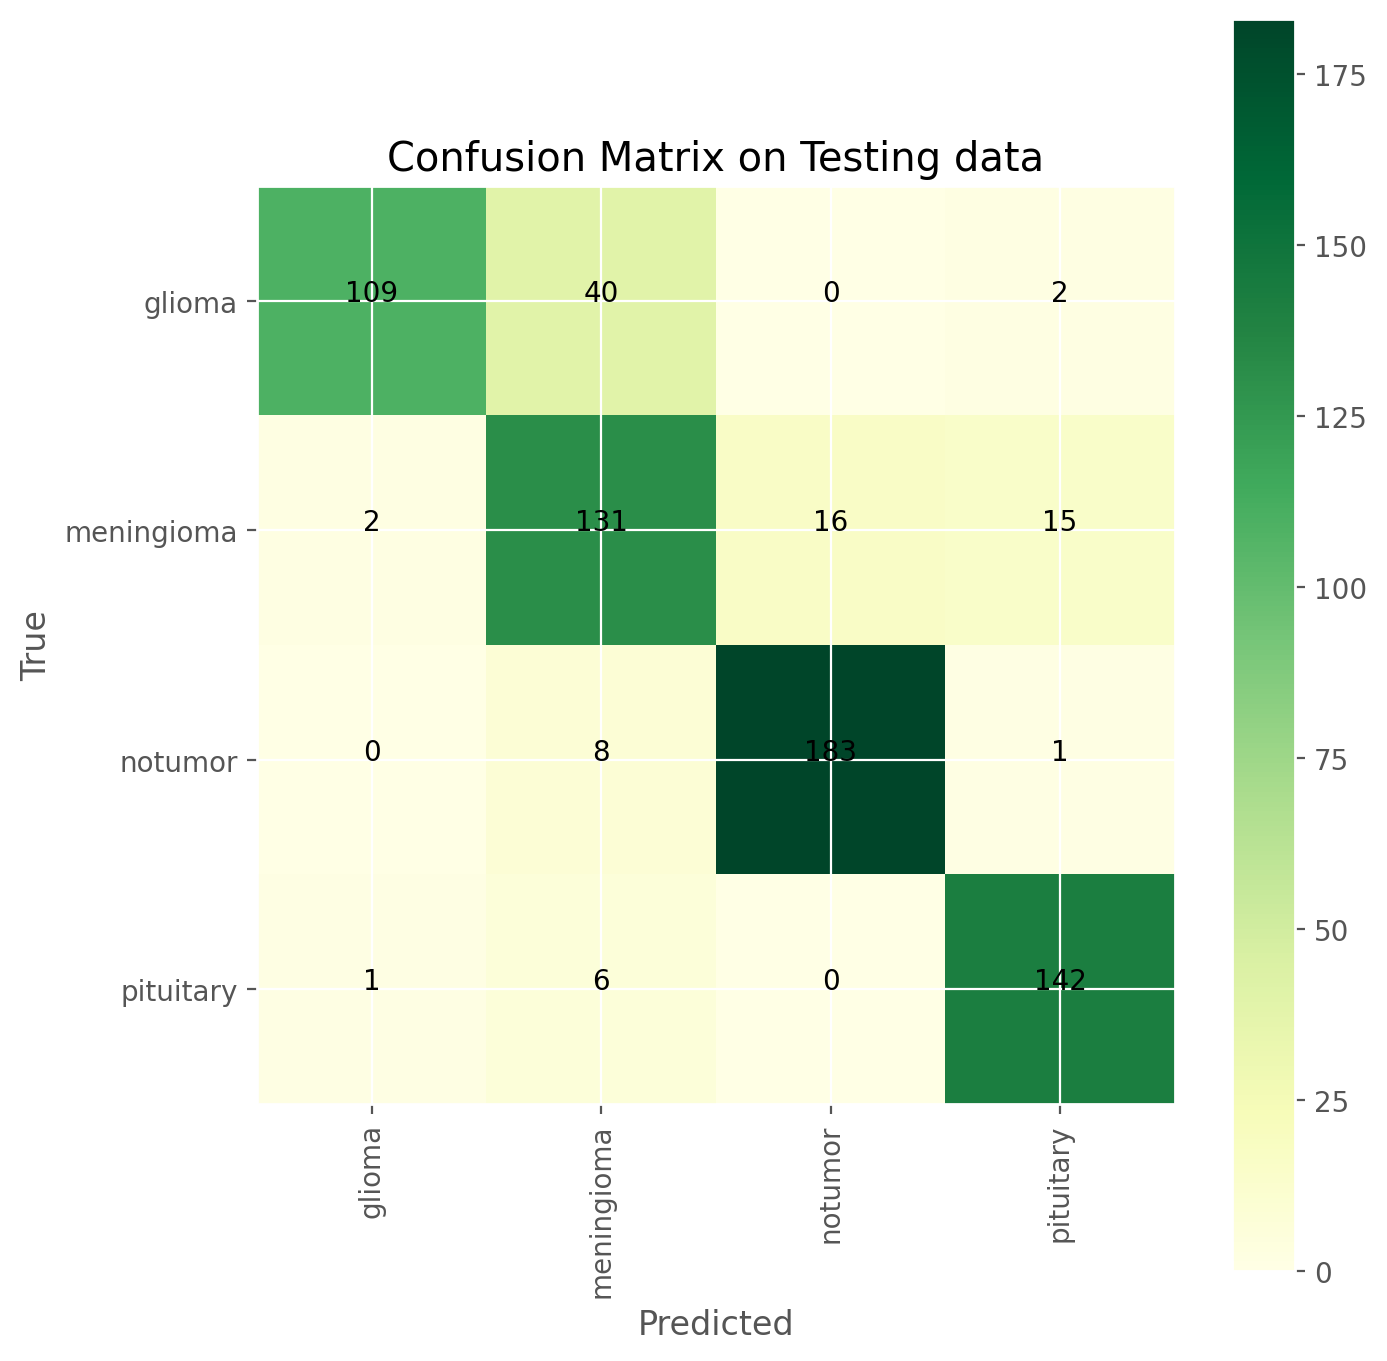

              precision    recall  f1-score   support

      glioma       0.97      0.72      0.83       151
  meningioma       0.71      0.80      0.75       164
     notumor       0.92      0.95      0.94       192
   pituitary       0.89      0.95      0.92       149

    accuracy                           0.86       656
   macro avg       0.87      0.86      0.86       656
weighted avg       0.87      0.86      0.86       656



In [ ]:
# invoke the function to plot cm
cm_report_effnet(model_effnet_2)

### Summary for EfficientNetB2

The customised EfficientNetB2 models have generally good accuracy scores on validation data for all 3 versions (at least 0.80). However the models with adam optimisers have a lower loss than when using RMSprop optimizer.

Adam optimiser:
  * Accuracy: 0.915
  * Loss: 0.221

RMSprop optimiser:
  * Accuracy: 0.861
  * Loss: 0.333

<br>

Interestingly for EfficientNetB2 on the RMSprop optimiser, it struggles to identify pituitary tumours more than the other two models - precision scores are lower.

Furthermore, for glioma tumors, it performed worse than the VGG16 model in terms of recall - which is not ideal because that would mean we have a higher amount of false negatives identified (i.e. patients with glioma tumors are identified as no tumors).

For meningioma tumors, recall was at least 0.80 which is still sufficiently good (though the other two models performed better) but it struggles with precision.

<br>

**Best model version for EfficientNetB2:**
EfficientNetB2 pretrained model using Adam optimiser (use early stopping)

---


### 5. Summary of results

In general, VGG16 is said to be the most commonly used model over the years for deep learning across varied uses [1,2,3]. Hence we will use it as the basis of comparison. 

In terms of medical imaging, there are studies which have attempted to use other pre-trained models such as ResNet and EfficientNet [1,3,5,6], but not necessarily on this same dataset. 

While considering computational resources and overall accuracy performances [4,7], I have decided to choose VGG16, Resnet50 and EfficientNetB2 to test on this particular dataset of images from Kaggle. The decision was also made as I realised the other users on Kaggle tend to create their own CNN models to train this dataset instead of using pre-trained models so I was curious to see what the results were.

<br>

<b> 1. Generalised Accuracy scores </b>

Out of our 3 pre-trained model types, the best one have been chosen based on overall accuracy and loss scores on the testing data set as well as ensuring "balanced" precision and recall scores for each model type.
  * VGG16 with Adam optimiser
  * ResNet50 with RMSprop optimiser
  * EfficientNetB2 with Adam optimiser

Accuracy score can be as high as 96% (VGG16). However ResNet50 model types have the lowest loss.

<br>

<b> 2. False positives Vs False negatives </b>

In clinical fields, having false predictions are generally not ideal. However as it is unavoidable, there comes the interesting debate of which is worse. 
Based on logic, having false negatives is considered "worse-off" on a societal level than false positives because that would mean missing a potential tumor or disease. As a result, most diagnostic tests are build to circumvent this as much as reasonably possible. But that could possibily mean that false positives will be overlooked and thus comes up more frequently in a scaled-up product and hence more discussions [8] tend to surround false-positives cases. In the case of Covid [9] or chronic diseases [10] for example, false positives cases are not ideal either as patients get exposed unncessarily to the virus due to isolation requirements or unncessary drug treatments when they are not infected.

On the other hand, there is the other perspective that in clinical trials [11], false negatives tend to have higher statistical errors hence are generally removed early in the process - which then results in a lack of accountability for it in scaled-up trials. 

As a result, it is important for balanced precision and recall scores.

<br>

<b> 3. F-1 Scores </b>

Further exploration of the metrics of the 4 tumors revealed interesting results.

To evaluate if the model performs well on identifying a particular tumor, we take into consideration high F-1 score in addition to considering "balanced" precision and recall scores so that the F-1 score will be as "true" as possible.

Furthere exploration of the metrics of each tumor type revealed that
1. ResNet50 with RMSprop performed the best in 2 tumors out of 4 - namely in meningiomas and gliomas. Even though they do not achieve the highest F-1 scores when compared to VGG16 model, it has a "truer" F1-score.

2. On images with no tumors, VGG16 with Adam performed the best at 99% (F-1 score).

3. For pituitary tumors, ResNet50 with Adam performed the best at 97% (F-1 score) with the highest score.

<br>

**Conclusion:**

As such, with all these considerations, ResNet50 with RMSprop (92.2% accuracy),  is considered to be the best model for predicting brain tumors.

Sources:
* [1] [Pre-trained deep learning models for brain MRI image classification](https://www.frontiersin.org/articles/10.3389/fnhum.2023.1150120/full#B11)
* [2] [A comparison between VGG16, VGG19 and ResNet50 architecture frameworks for Image Classification](https://ieeexplore.ieee.org/document/9687944/figures#figures)
* [3] [Detection and analysis of COVID-19 in medical images using deep learning techniques](https://www.researchgate.net/publication/355049790_Detection_and_analysis_of_COVID-19_in_medical_images_using_deep_learning_techniques)
* [4] [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)
* [5] [Automation of Brain Tumor Identification using EfficientNet on Magnetic Resonance Images](https://www.sciencedirect.com/science/article/pii/S187705092300133)
* [6] [Multi-class classification of brain tumor types from MR images using EfficientNets](https://www.sciencedirect.com/science/article/abs/pii/S1746809423002100)4
* [7] [How to Choose the Best Keras Pre-Trained Model for Image Classification](https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4)
* [8] [Which is worse: False-positive or false-negative?](https://www.linkedin.com/pulse/which-worse-false-positive-false-negative-miha-mozina-phd/)
* [9] [The impact of false positive COVID-19 results in an area of low prevalence](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7850182)
* [10] [Psychosocial consequences of false-positive newborn screens for cystic fibrosis](https://pubmed.ncbi.nlm.nih.gov/20852016/)
* [11] [The Burden of the “False‐Negatives” in Clinical Development: Analyses of Current and Alternative Scenarios and Corrective Measures](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6402187/)